# 0.0 Imports

In [1]:
import math
import random
import pickle
import numpy as np
import seaborn as sns
import inflection
import pandas as pd
import xgboost as xgb



from PIL                     import Image
from boruta                  import BorutaPy
from tabulate                import tabulate
from IPython.display         import Image
from IPython.core.display    import HTML 
from sklearn.preprocessing   import LabelEncoder
from pycorrcat.pycorrcat     import plot_corr, corr_matrix
from sklearn.ensemble        import RandomForestRegressor
from sklearn.preprocessing   import RobustScaler, MinMaxScaler
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.metrics         import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

## 0.1 Help Functions

In [2]:
def cross_validation(xtraining, kfold, model_name, model, verbose=False): 
    
    #list to add the values
    mae_list  = []
    mape_list = []
    rmse_list = []
    
    for k in reversed( range (kfold + 1 ) ):
        if verbose:
            
            print('\nKfold Number: {}'.format(k) )

        #start date of validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k *6 *7)

        #end date of validation
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1) * 6 *7 )

        #filtering the date
        #collect all the features are less that the date validation start
        training   = x_training.loc[x_training['date'] < validation_start_date]

        #collect the features greater that is less than the date validation start and end
        validation = x_training.loc[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        #drop the columns date and sales to training the model
        xtraining = training.drop(['date','sales'], axis=1)
        ytraining = training['sales']

        #drop the columns date and sales to validation the model
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        #model the to be training
        m = model.fit(xtraining, ytraining)

        #prediction
        yhat = m.predict(xvalidation)

        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat) )

        mae_list.append(  m_result['Mae'] )
        mape_list.append( m_result['Mape'] )
        rmse_list.append( m_result['Rmse'] )

        #the calc mean and std of each kfold interation
    return pd.DataFrame( {'Model Name':model_name,
                          'MAE  CV':np.round( np.mean( mae_list),2 ).astype(str)  + ' +/- '  + np.round( np.std(mae_list),2 ).astype(str),
                          'MAPE CV':np.round( np.mean( mape_list),2 ).astype(str) + ' +/- ' + np.round( np.std(mape_list),2 ).astype(str),
                          'RMSE CV':np.round( np.mean( rmse_list),2 ).astype(str) + ' +/- ' + np.round( np.std(rmse_list),2 ).astype(str) },
                           index = [0] )

def ml_error(model_name, y, yhat):
    mae  = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt( mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model name': model_name,
                        'Mae':  mae,
                        'Mape': mape,
                        'Rmse': rmse}, index=[0] )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/guilherme/Documentos/repos/datascienceemproducao/datascienceemproducao/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Loading Data

In [3]:
df_sales = pd.read_csv('/home/guilherme/Documentos/repos/datascienceemproducao/data/train.csv',low_memory=False)

df_store = pd.read_csv('/home/guilherme/Documentos/repos/datascienceemproducao/data/store.csv',low_memory=False)

#merge
df_raw = pd.merge(df_sales,df_store,how= 'left', on='Store')

# 1.0 Descrition Data

In [5]:
df1 = df_raw.copy(deep=True)

## 1.1  Rename Columns

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

#function to convent columns format snackcase
snackcase= lambda x: inflection.underscore( x )


cols_new= list( map( snackcase, cols_old ))

#rename columns 

df1.columns = cols_new



## 1.2 Data Dimensions

In [8]:
print('The number of    Rows: {}'.format(df1.shape[0]))
print('The number of Columns: {}'.format(df1.shape[1]))

The number of    Rows: 1017209
The number of Columns: 18


## 1.3 Data Types

In [9]:
# convent the colum data to datetime64
df1['date'] = df1['date'].astype('datetime64[ns]')

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.4.1 Check NA %

In [11]:
df1.isna().sum() / df1.shape[0] * 100

store                            0.000000
day_of_week                      0.000000
date                             0.000000
sales                            0.000000
customers                        0.000000
open                             0.000000
promo                            0.000000
state_holiday                    0.000000
school_holiday                   0.000000
store_type                       0.000000
assortment                       0.000000
competition_distance             0.259730
competition_open_since_month    31.787764
competition_open_since_year     31.787764
promo2                           0.000000
promo2_since_week               49.943620
promo2_since_year               49.943620
promo_interval                  49.943620
dtype: float64

## 1.5 FillOut NA

In [12]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x )



df1['competition_open_since_month']= df1.apply(lambda x: x['date'].month if 
                                               math.isnan(x['competition_open_since_month']) 
                                               else x['competition_open_since_month'], axis=1)



df1['competition_open_since_year']= df1.apply(lambda x: x['date'].year if
                                              math.isnan(x['competition_open_since_year']) 
                                              else x['competition_open_since_year'],axis=1)


df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week'])
                                     else x['promo2_since_week'],axis=1)

df1['promo2_since_year']= df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year'])
                                     else x['promo2_since_year'],axis=1)


#dict of year to month
month_map = {1: 'Jan',2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May',
             6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov' ,12: 'Dec' }


#substituindo NA por 0
df1['promo_interval'].fillna(0,inplace=True)

#extract month data 
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x:0 if x['promo_interval']==0 
                                                            else 1 if x['month_map'] in x['promo_interval'].split( ',' ) 
                                                            else 0,axis=1)


In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [14]:


df1['promo2_since_week']  = df1['promo2_since_week'] .astype(int)

df1['promo2_since_year']  = df1['promo2_since_year'] .astype(int)

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

df1['competition_open_since_year'] =  df1['competition_open_since_year'].astype(int)

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descrptive Statistics

In [15]:
num_attributes = df1.select_dtypes( include = ['int64','float64'] )

cat_attributes = df1.select_dtypes( exclude = ['int64','float64','datetime64[ns]'] )

## 1.7.1 Numeric Attributes

In [16]:
#tendecy Central

#mean and median 

t1 = pd.DataFrame(num_attributes.apply(lambda x: np.mean( x ) ) ).T
t2 = pd.DataFrame(num_attributes.apply(lambda x: np.median( x ) ) ).T

# min - max - std - range - skew - kurtose

#min 
d1 = pd.DataFrame(num_attributes.apply(lambda x: np.min(x) ) ).T

#max
d2 = pd.DataFrame(num_attributes.apply(lambda x: np.max(x) ) ).T

#range

d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() ) ).T

#std 

d4 = pd.DataFrame(num_attributes.apply(lambda x: np.std(x) ) ).T

#skew

d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() ) ).T

#kurtosis
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() ) ).T

#concat metrics
m1 = pd.concat([t1,t2,d1,d2,d3,d4,d5,d6]).T.reset_index()

#rename columns
m1.columns = ['attributes','mean','median','min','max','range','std','skew','kurtosis']
m1

,attributes,mean,median,min,max,range,std,skew,kurtosis
0,store,558.429727,558.0,1.0,1115.0,1114.0,321.908493,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.0,7.0,6.0,1.997390,0.001593,-1.246873
2,sales,5773.818972,5744.0,0.0,41551.0,41551.0,3849.924283,0.641460,1.778375
3,customers,633.145946,609.0,0.0,7388.0,7388.0,464.411506,1.598650,7.091773
4,open,0.830107,1.0,0.0,1.0,1.0,0.375539,-1.758045,1.090723
5,promo,0.381515,0.0,0.0,1.0,1.0,0.485758,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.0,1.0,1.0,0.383056,1.677842,0.815154
7,competition_distance,5935.442677,2330.0,20.0,200000.0,199980.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,6.786849,7.0,1.0,12.0,11.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,1900.0,2015.0,115.0,5.515591,-7.235657,124.071304


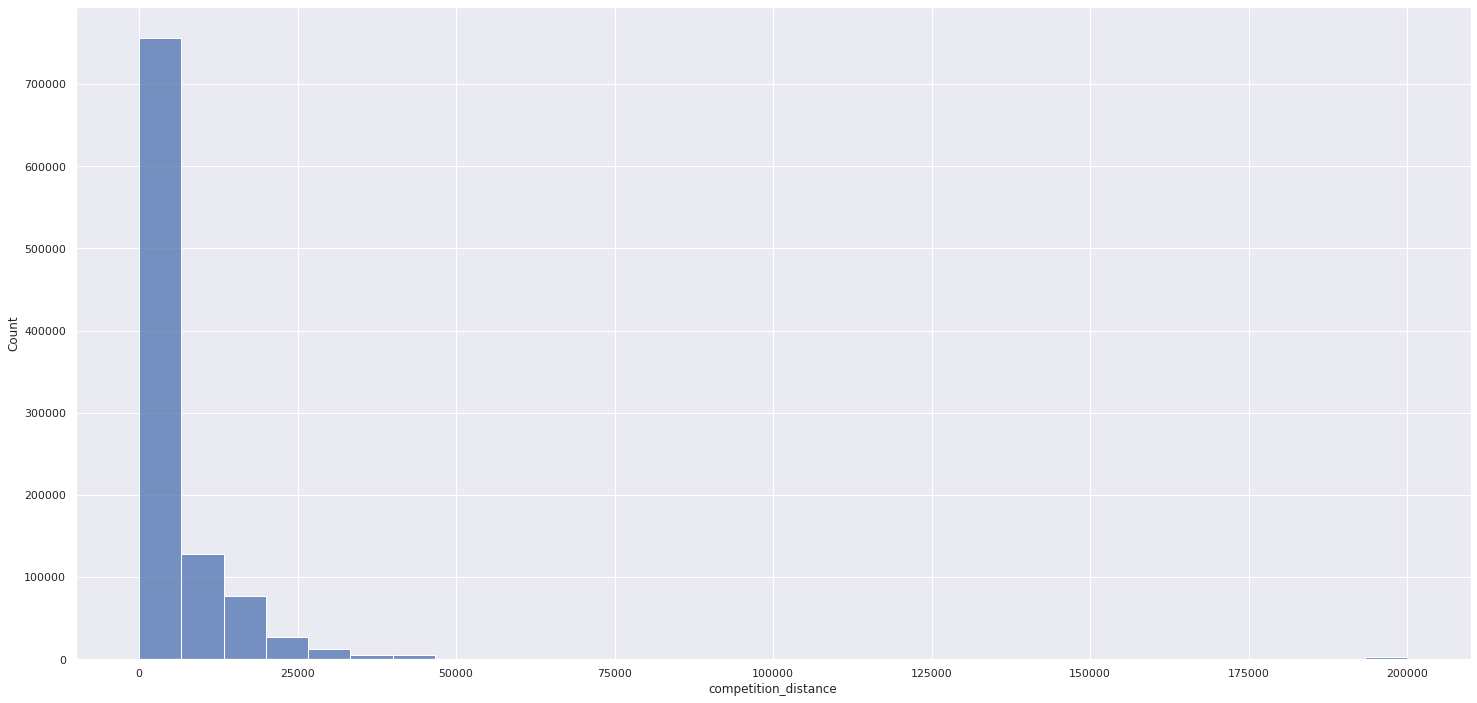

In [17]:
sns.histplot(df1['competition_distance'],bins=30);

## 1.7.2 Categorical Attributes

In [18]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

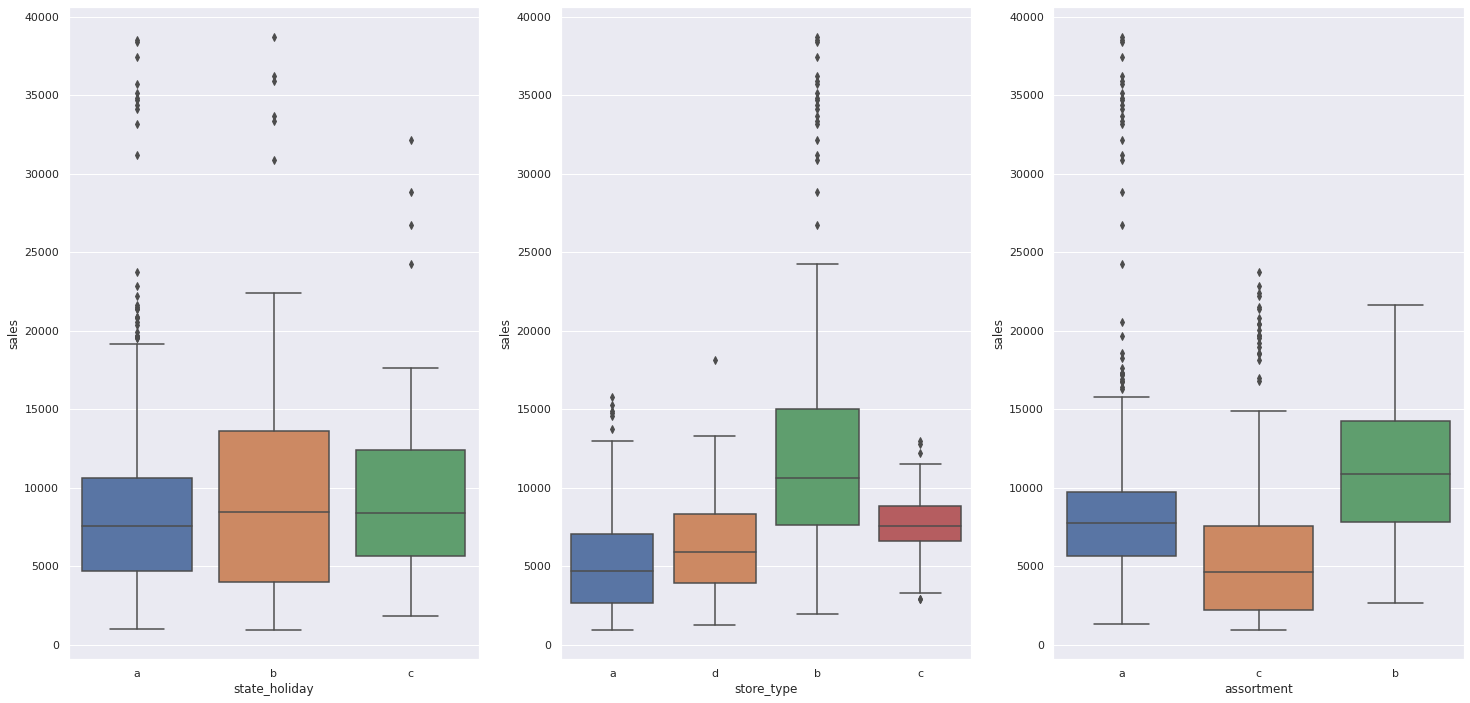

In [19]:
#filter the data
aux1 = df1[(df1['state_holiday']!= '0') & (df1['sales']> 0) ]

#state holiday
plt.subplot(1,3,1)
sns.boxplot(x= 'state_holiday', y='sales', data=aux1);

#store_type
plt.subplot(1,3,2)
sns.boxplot(x= 'store_type', y='sales', data=aux1);

#assortment
plt.subplot(1,3,3)
sns.boxplot(x= 'assortment', y='sales', data=aux1);

# 2.0 Feature Engineering

In [20]:
df2= df1.copy(deep=True)

## 2.1 Mind Map Hpyothesis

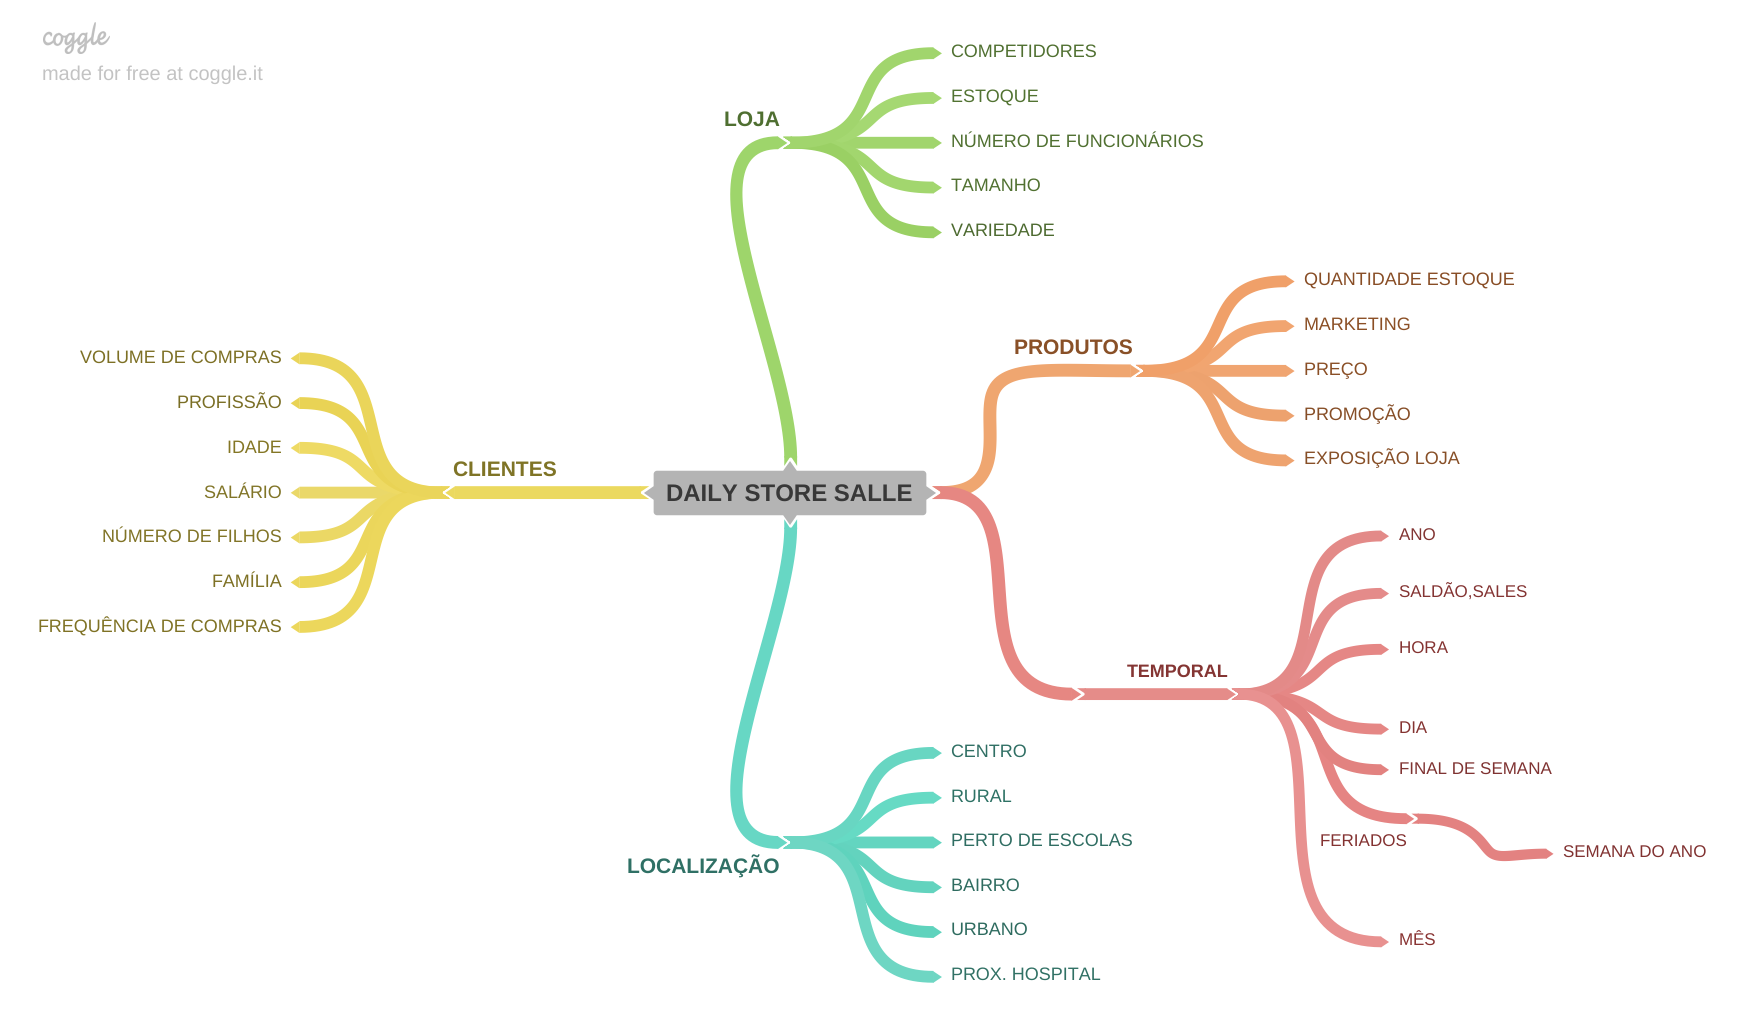

## 2.2 - List Hpyothesis

## 2.2.1 Store Hpyothesis 

**1** . Lojas com número maior de fúncionários deveriam vender mais.

**2**. Lojas com maior variedades de produtos deveriam vender mais.

**3**. Lojas com maior porte deveriam vender mais.

**4**. Lojas com maior capacidade de estoque deveriam vender mais.

**5**. Lojas com competidores mais próximo deveriam venderiam mais.

**6**. Lojas com competidores à mais tempo deveriam vender mais.

## 2.2.2 Product Hpyothesis

**1**. Lojas que fazem mais ação de marketing deveriam vender mais.

**2**. Lojas com mais exposição dos seus produtos deveriam vender mais.

**3**. Lojas que ativam promoções por mais tempo deveriam vender mais.

**4**. Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5**. Lojas com mais promoções deveriam vender mais.

**6**. Lojas com mais promoções consecutivas deveriam vender mais.

**7**. Lojas que tem preços mais baixos deveriam vender mais.

**8**. Lojas com mais produtos em estoque deveriam vender mais.

## 2.2.3 Temporal Hpyothesis

**1**. Lojas abertas no feriaodo de Natal deveriam vender mais.

**2**. Lojas deveriam vender mais ao longo dos anos.

**3**. Lojas deveriam vender mais depois do dia 10 de cada mês.

**4**. Lojas deveriam vender menos aos finais de semana.

**5**. Lojas deveriam vender mais no segundo semestre do ano.

**6**. Lojas deveriam vender menos nos feriaods escolares.

## 2.3 List Final Hpyothesis

**1**. Lojas com maior sortimentos deveriam vender mais.

**2**. Lojas com competidores mais próximos deveriam vender menos.

**3**. Lojas com competidores à mais tempo deveriam vendem mais.

**4**. Lojas com promoções ativas por mais tempo deveriam vender mais.

**5**. Lojas com mais dias de promoção deveriam vender mais.

**7**. Lojas com mais promoções consecutivas deveriam vender mais.

**8**. Lojas abertas durante o feriado de Natal deveriam vender mais.

**9**. Lojas deveriam vender mais ao longo dos anos.

**10**. Lojas deveriam vender mais no segundo semestre do ano.

**11**. Lojas deveriam vender mais depois do dia 10 de cada mês.

**12**. Lojas deveriam vender menos aos finais de semana.

**13**. Lojas deveriam vender menos durante os feriados escolares.



## 2.4 Feature Engineering

In [21]:
df2['year']= df2['date'].dt.year

df2['month'] = df2['date'].dt.month

df2['day'] = df2['date'].dt.day

df2['week_of_year'] = df2['date'].dt.isocalendar().week

df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                               month=x['competition_open_since_month'],
                                                               day=1),axis=1)

df2['compettion_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply(lambda x: x.days).astype(int)

#join the columns promo2
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

# convent promo time week to datetime
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1','%Y-%W-%w') - datetime.timedelta(days=7) )


#calcule between start promo and continuation 
df2['promo_time_week'] = (( df2['date'] - df2['promo_since'] ) /7 ).apply(lambda x: x.days).astype(int)

# renome names assortment 
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x== 'a' else 'extra' if x =='b'else 'extended')

#rename state holiday

df2['state_holiday']= df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' 
                                                 else 'easter_holiday' if x=='b' 
                                                 else 'christmas' if x=='c'
                                                 else 'regular_day')

# 3.0 Variable Filtering

In [22]:
df3 = df2.copy(deep=True)

## 3.1 Filtering the data

In [23]:
#filtereing the rows open and sales of dataset

df3= df3.loc[(df3['open'] > 0) & (df3['sales'] > 0) ] 

## 3.2 Select the columns

In [24]:
cols_drop= ['customers','open','promo_interval','month_map']

df3 = df3.drop( cols_drop,axis=1 )

# 4 EDA

In [25]:
df4 = df3.copy(deep=True)

## 4 .1  Analise Univariada

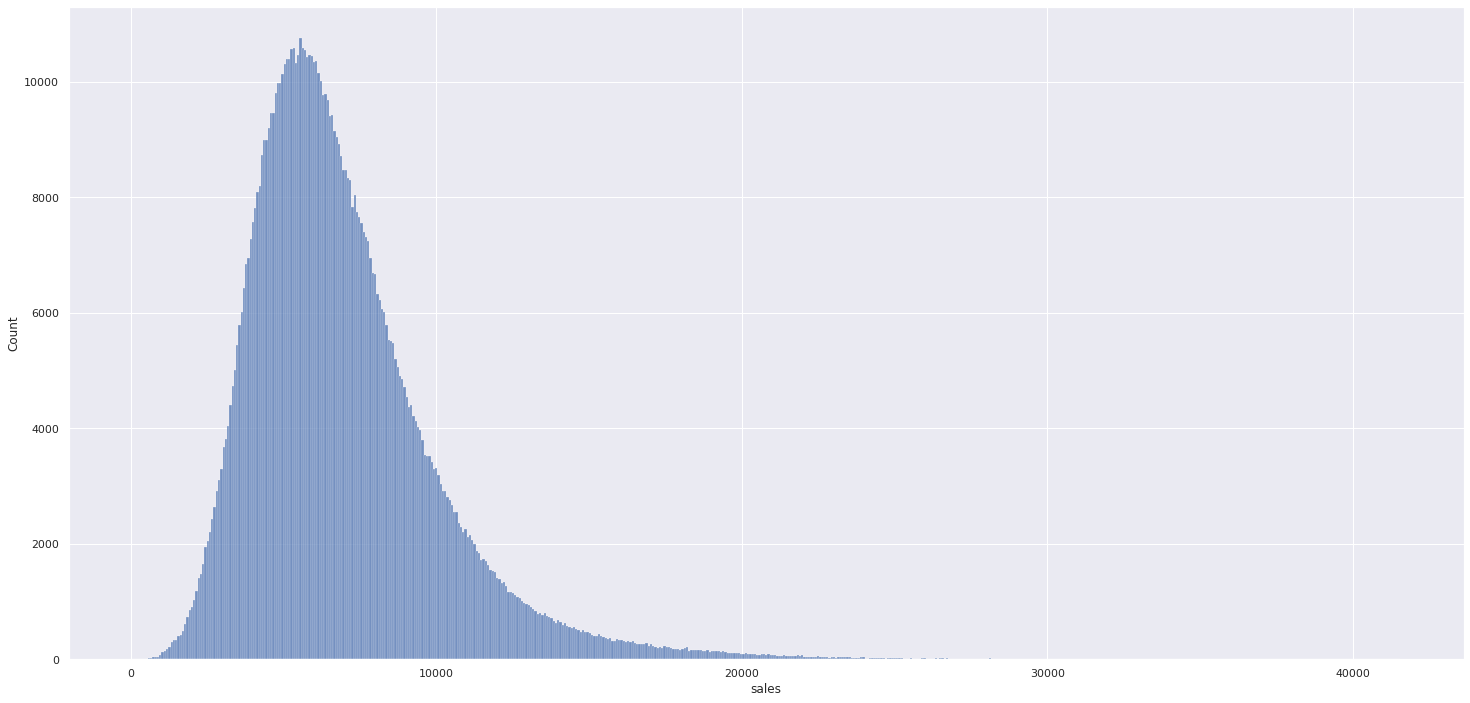

In [26]:
sns.histplot( df4['sales'] );

## Numeric Variable

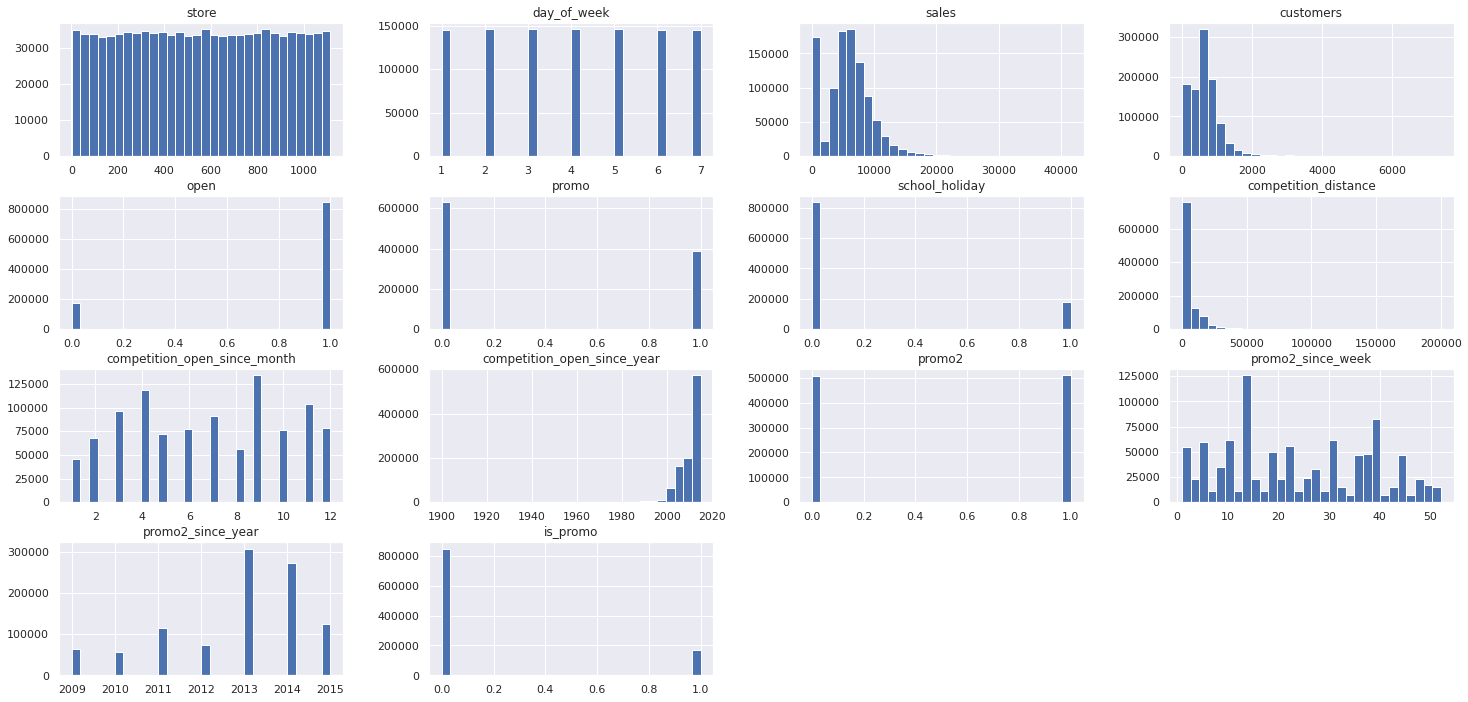

In [27]:
num_attributes.hist(bins=30);

* Plot Store: Não há diferença significativa de vendas entre lojas;
* Plot day of week : Não há nenhum dia especifico da semana que há um aumento nas vendas;
* Plot Sales: 
* Plot Customers: Neste demostra que quando há uma concetração maior de clientes nas lojas gerlamene há um aumento nas vendas;
* Plot open : Como esperados lojas abertas tem vendas maiores;
* Plot Promo : Neste plot há uma certa supresa. Há uma probabilidade maior de não ter vendas maiores quando há promoções;
* Plot School Holiday: Como já é esperado as vendas maiores são em dias regulares;
* Plot Competition Distance: Plot aponta que as vendas são maiores quando há competidores mais próximos. 
* Plot Competition Open Since Month: Neste plot é possível observar que os mês com maior pico de vendas é no mês 9;
* Plor Competition Open Since Year: No plot no período vendas anual é é possível observar que após ano de 2010 houve aumento nas vendas;
* Plot Promo2: Neste gráfico é possível analisar algo interessante. Que a continuação da promoção não afeta as chances de vender mais;
* Plot Promo Since Week: Neste plot semanal é observado que há um pico de vendas entre a semana 10 à 20. É necessário uma analisa mais aprofundada para saber o motivo de geralmente as promoções funcionarem melhor neste período. 
* Promo2 Since Year: Neste plot é possível concluir que o ano de 2013 e 2014 tiveram vendas bem significativas em relação aos demais anos;
* Is Promo: Neste gráfico é demostrado algo geralmente incomum na área de vendas. As promoções tem efeito menor nas vendas. 

## Categoric Variable

In [28]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [29]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

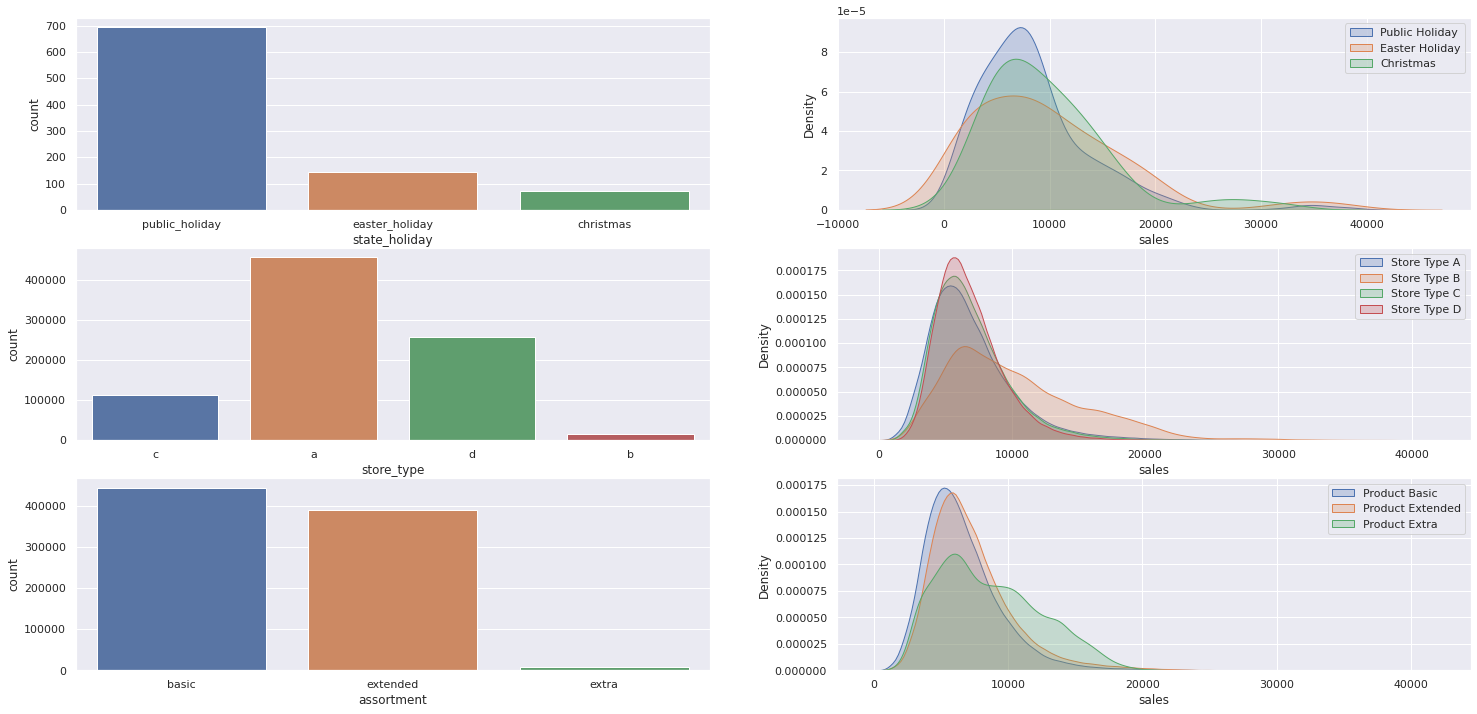

In [30]:
#comparando as vendas dos feriados
plt.subplot(3,2,1)

aux = df4[df4['state_holiday']!= 'regular_day']

sns.countplot(x='state_holiday', data = aux);

plt.subplot(3,2,2)
sns.kdeplot(df4.loc[df4['state_holiday']=='public_holiday']['sales'],label= 'Public Holiday',shade=True);
sns.kdeplot(df4.loc[df4['state_holiday']=='easter_holiday']['sales'],label= 'Easter Holiday',shade=True);
sns.kdeplot(df4.loc[df4['state_holiday']=='christmas']['sales'],label= 'Christmas',shade=True);
plt.legend(loc='best');

#store type
plt.subplot(3,2,3)
sns.countplot(x='store_type',data= df4);

plt.subplot(3,2,4)
sns.kdeplot(df4.loc[df4['store_type'] == 'a']['sales'], label='Store Type A',shade=True);
sns.kdeplot(df4.loc[df4['store_type'] == 'b']['sales'], label='Store Type B',shade=True);
sns.kdeplot(df4.loc[df4['store_type'] == 'c']['sales'], label='Store Type C',shade=True);
sns.kdeplot(df4.loc[df4['store_type'] == 'd']['sales'], label='Store Type D',shade=True);
plt.legend(loc='best');
#assortment

plt.subplot(3,2,5)
sns.countplot(x='assortment',data=df4);

plt.subplot(3,2,6)
sns.kdeplot(df4.loc[df4['assortment'] == 'basic']['sales'], label='Product Basic',shade=True);
sns.kdeplot(df4.loc[df4['assortment'] == 'extended']['sales'], label='Product Extended',shade=True);
sns.kdeplot(df4.loc[df4['assortment'] == 'extra']['sales'], label='Product Extra',shade=True);
plt.legend(loc='best');

## 4.2 Analise Bivariada

## H1 . Lojas com número maior de fúncionários deveriam vender mais.

## H2. Lojas com maior variedades de produtos deveriam vender mais.

### Falsa - Lojas com MAIS sortimentos vendem MENOS

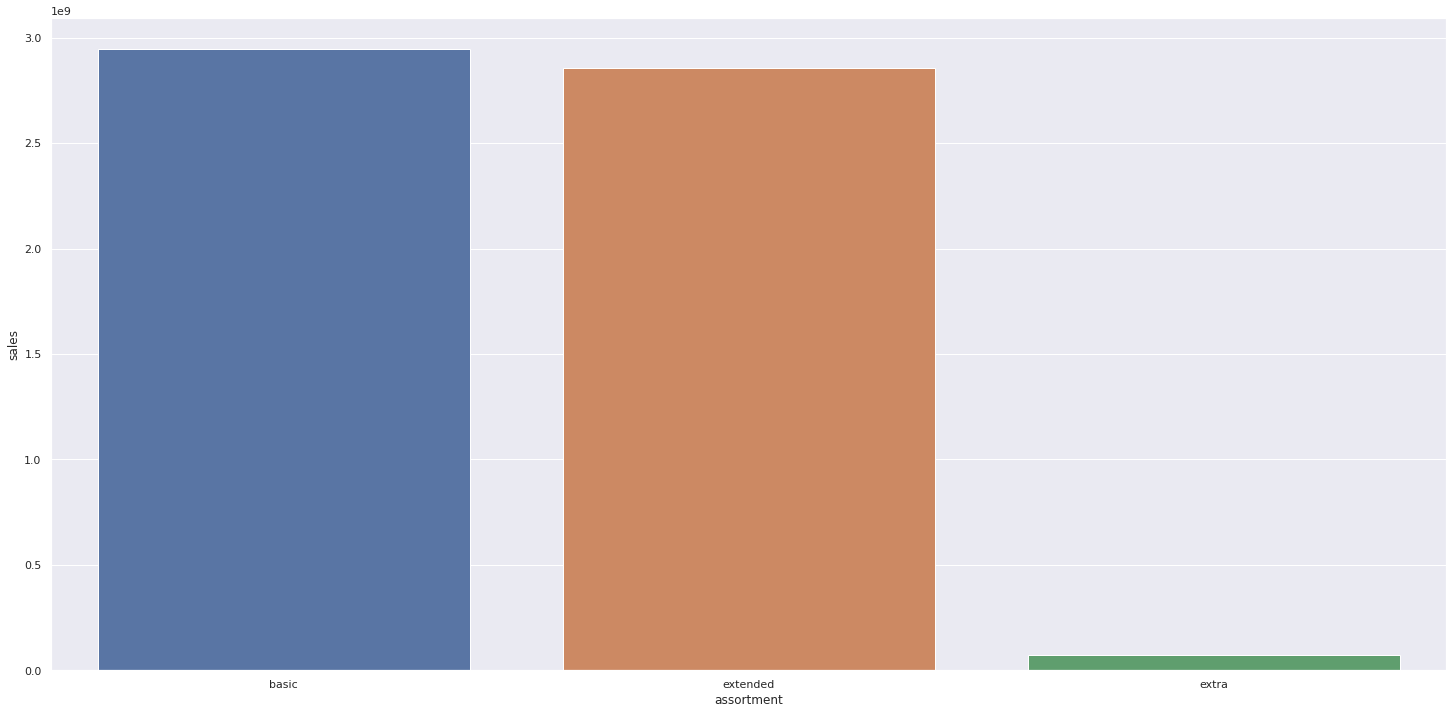

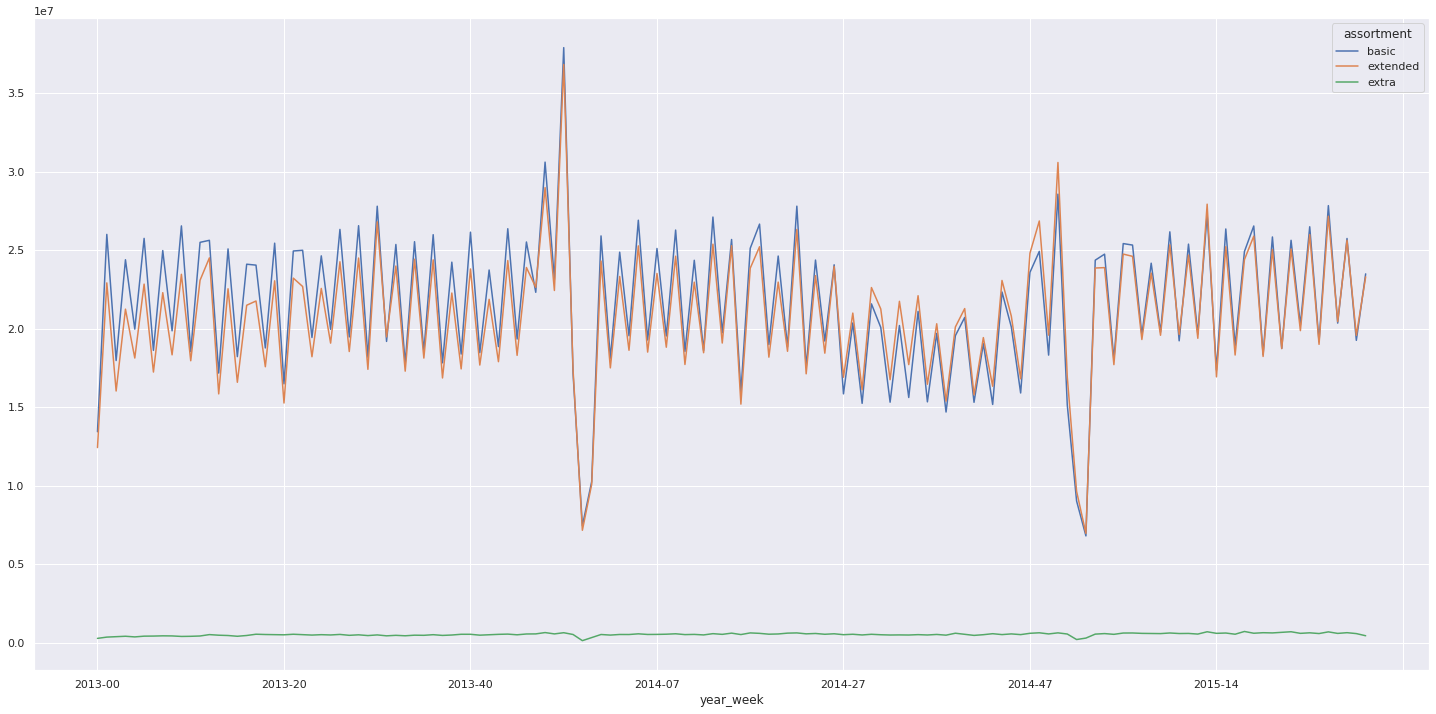

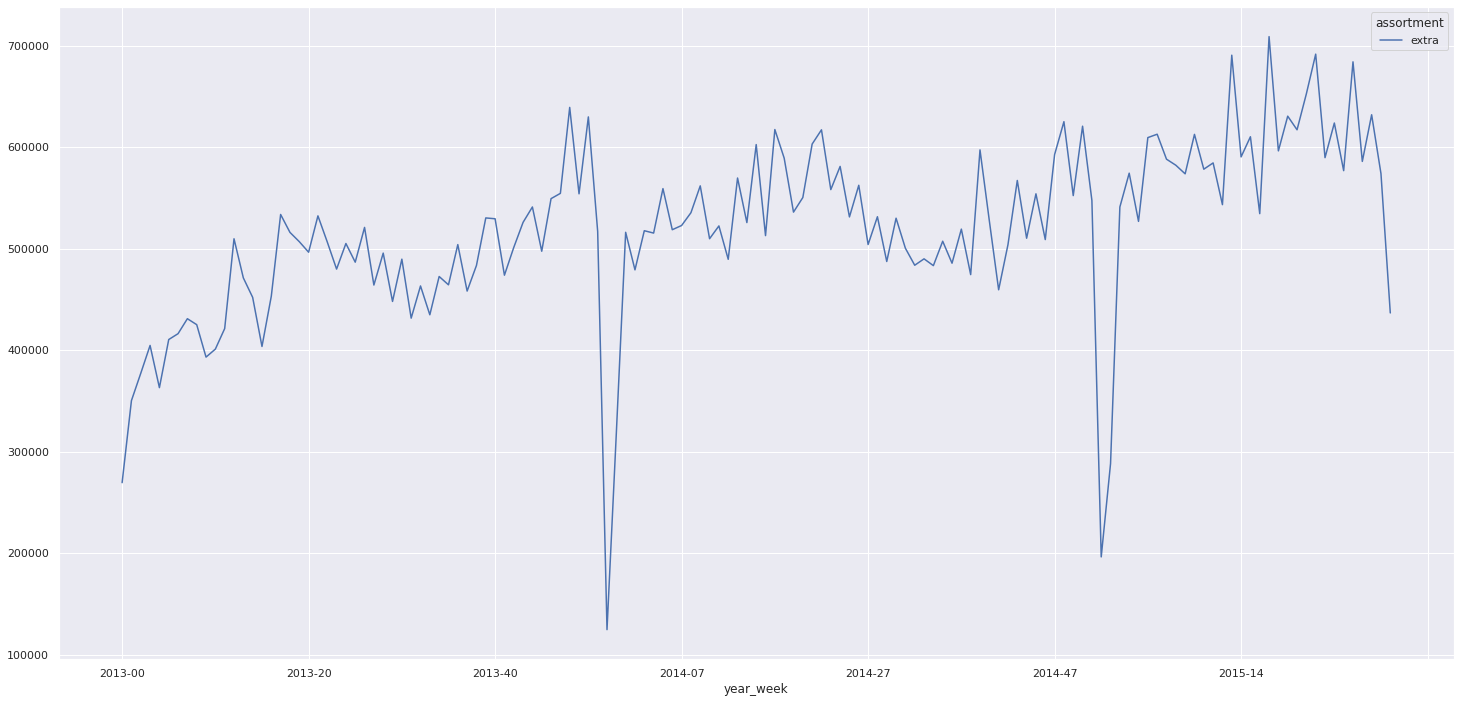

In [31]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()

sns.barplot(x='assortment',y='sales', data = aux1);


aux2 = df4[['assortment','sales','year_week']].groupby(['assortment','year_week']).sum().reset_index()

aux2.pivot(index='year_week',columns='assortment',values='sales').plot();


aux3 = aux2.loc[aux2['assortment']=='extra']
aux3.pivot(index= 'year_week', columns='assortment', values='sales').plot();

## H3 - Lojas com competidores mais próximo deveriam venderiam menos.

### Falso: Lojas vendem mais com competidores mais próximo.

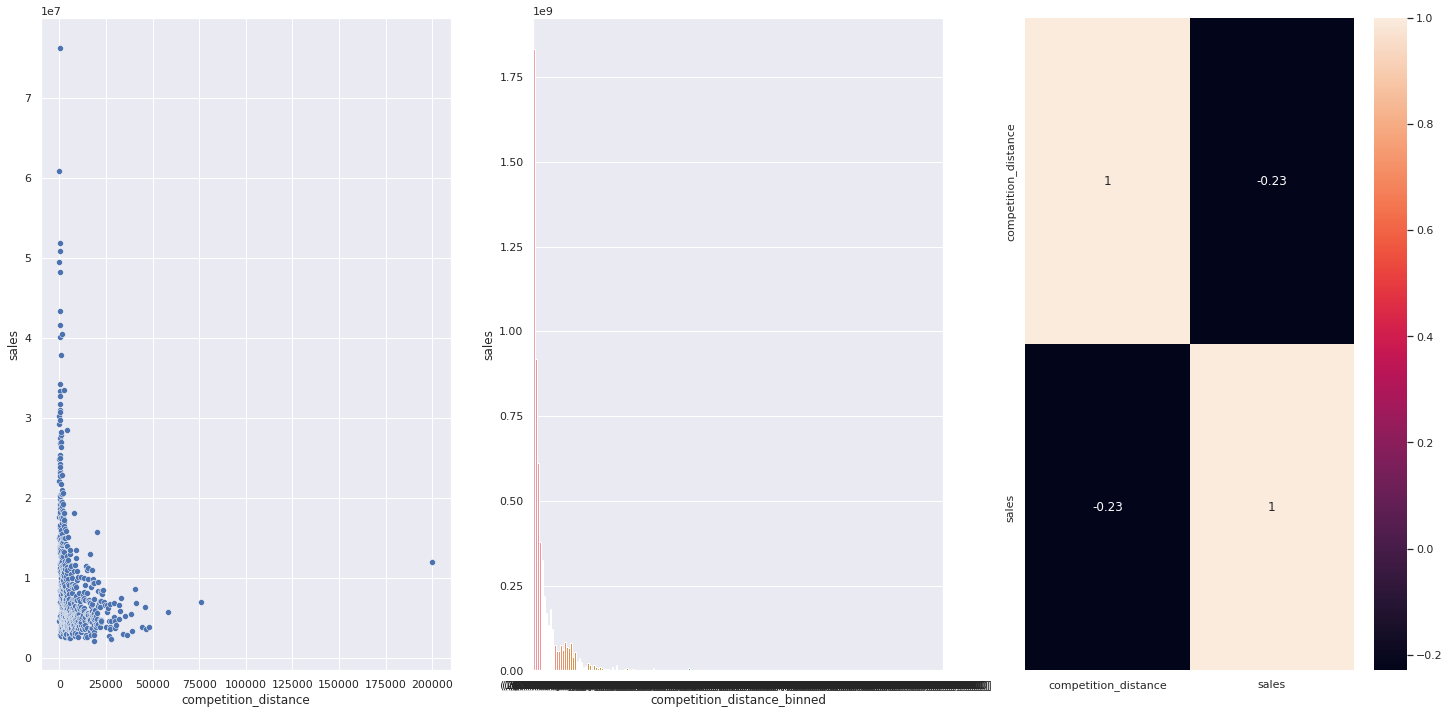

In [32]:
plt.subplot(1,3,1)

aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

sns.scatterplot(x= 'competition_distance', y = 'sales', data = aux1)

plt.subplot(1,3,2)

#agrupando a disntancia em grupos
bins = list(np.arange(0,200000,1000))

#encaixando o grupos criados em uma nova coluna 
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)

aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

sns.barplot(x = 'competition_distance_binned', y= 'sales', data = aux2);

plt.subplot(1,3,3)
#heatmap
sns.heatmap(aux1.corr(method='pearson'),annot=True);



## H4 - Lojas com competidores à mais tempo deveriam vender mais.

### Falso: Lojas compentidores à mais tempo vendem menos.

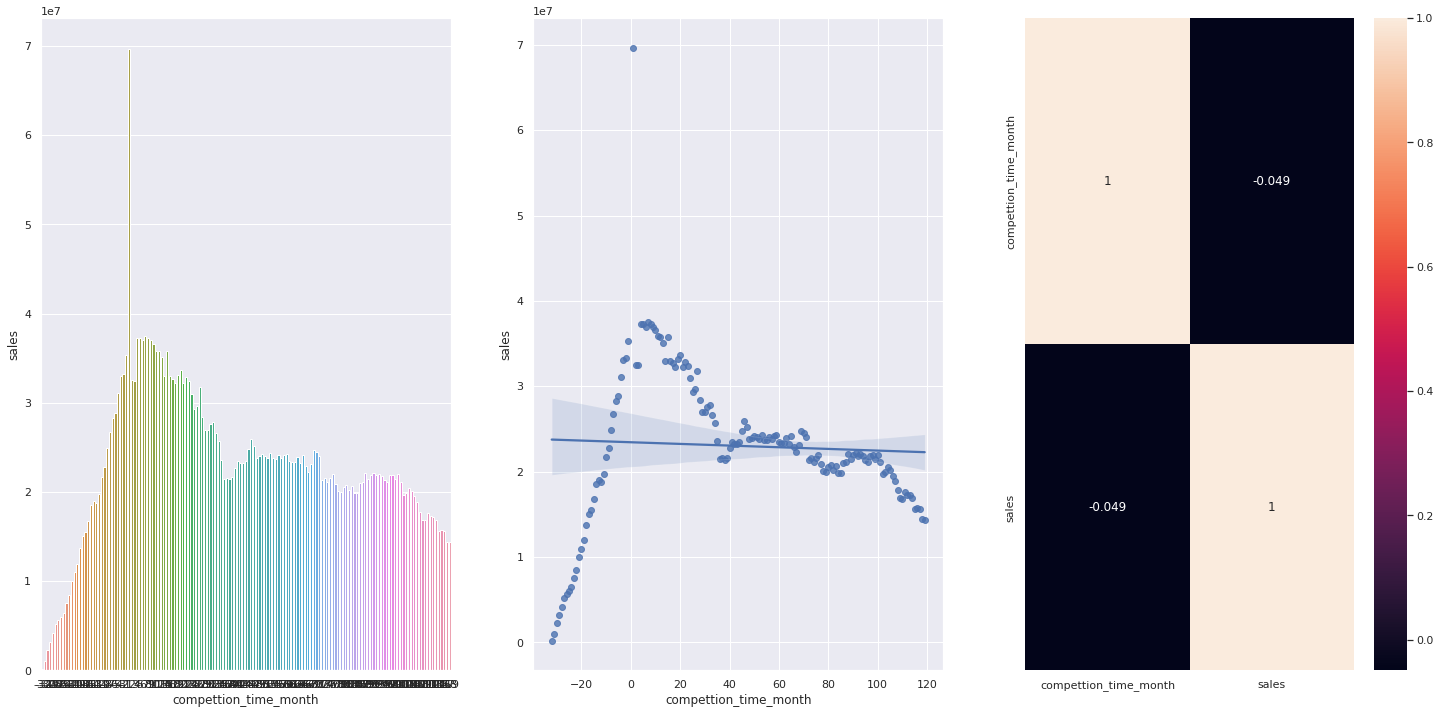

In [33]:
aux1 = df4[['compettion_time_month','sales']].groupby('compettion_time_month').sum().reset_index()

aux2 = aux1[(aux1['compettion_time_month'] < 120) & (aux1['compettion_time_month']!= 0)]

plt.subplot(1,3,1)
sns.barplot(x ='compettion_time_month', y = 'sales', data= aux2 );

plt.subplot(1,3,2)
sns.regplot(x = 'compettion_time_month', y = 'sales' , data= aux2);

plt.subplot(1,3,3)
sns.heatmap(aux2.corr(method='pearson'), annot= True);

## H5 - Lojas que ativam promoções por mais tempo deveriam vender mais.

### Falso: Lojas que tem promoões por mais tempo vendem menos

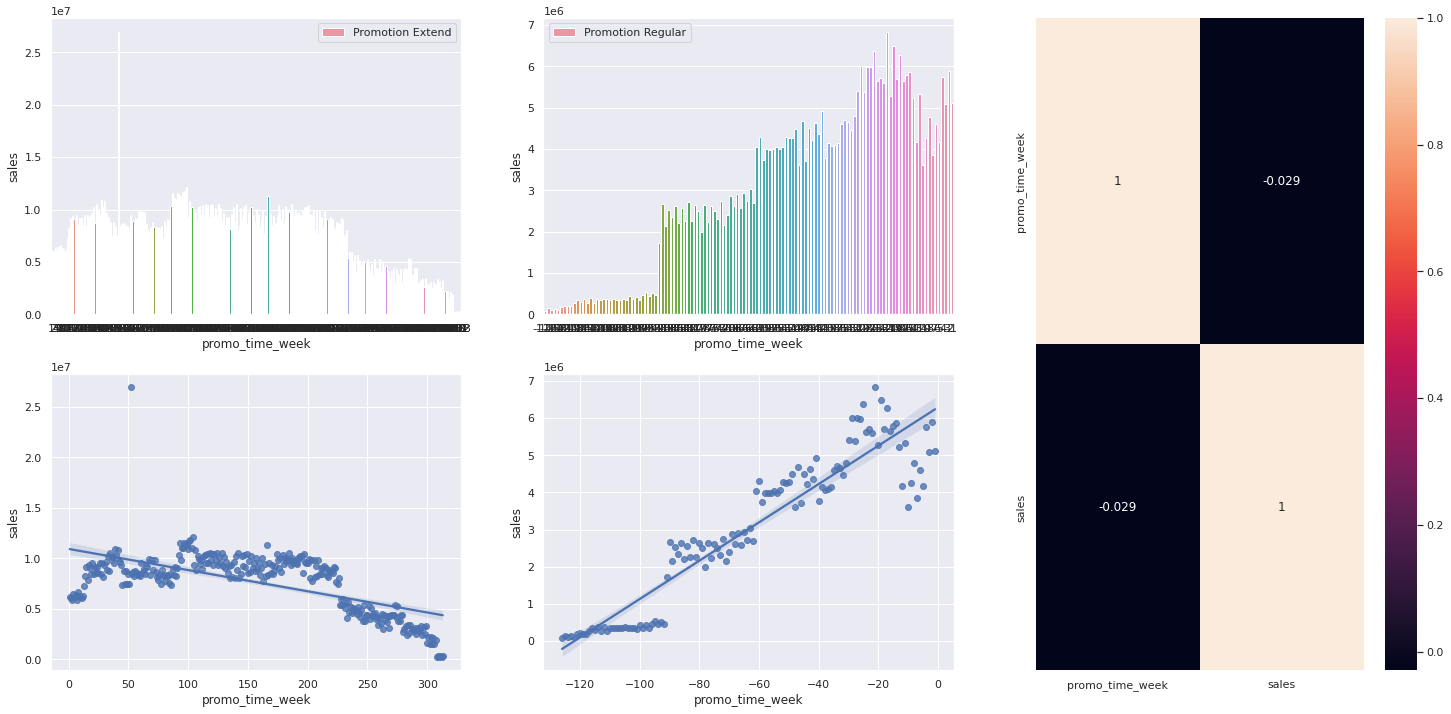

In [34]:
# ======= Promotion extend ========================= #

aux = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2 ,3)

aux1 = aux.loc[aux['promo_time_week']> 0]

plt.subplot( grid[0,0] )
sns.barplot(x= 'promo_time_week', y = 'sales', data=aux1, label= 'Promotion Extend');
plt.legend(loc='best');

plt.subplot( grid[1,0] )
sns.regplot(x = 'promo_time_week', y= 'sales', data=aux1);

plt.subplot(grid[0,1])


# ================== Promotion Regular =================

aux3 = aux.loc[aux['promo_time_week']< 0]

sns.barplot(x= 'promo_time_week', y = 'sales', data=aux3, label= 'Promotion Regular');
plt.legend(loc='best');

plt.subplot( grid[1,1] )
sns.regplot(x = 'promo_time_week', y= 'sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux.corr(method='pearson'), annot=True);

## H6- Lojas com mais promoções consecutivas deveriam vender mais.

### Falso - Lojas com mais promoções sucessivas não vendem mais.

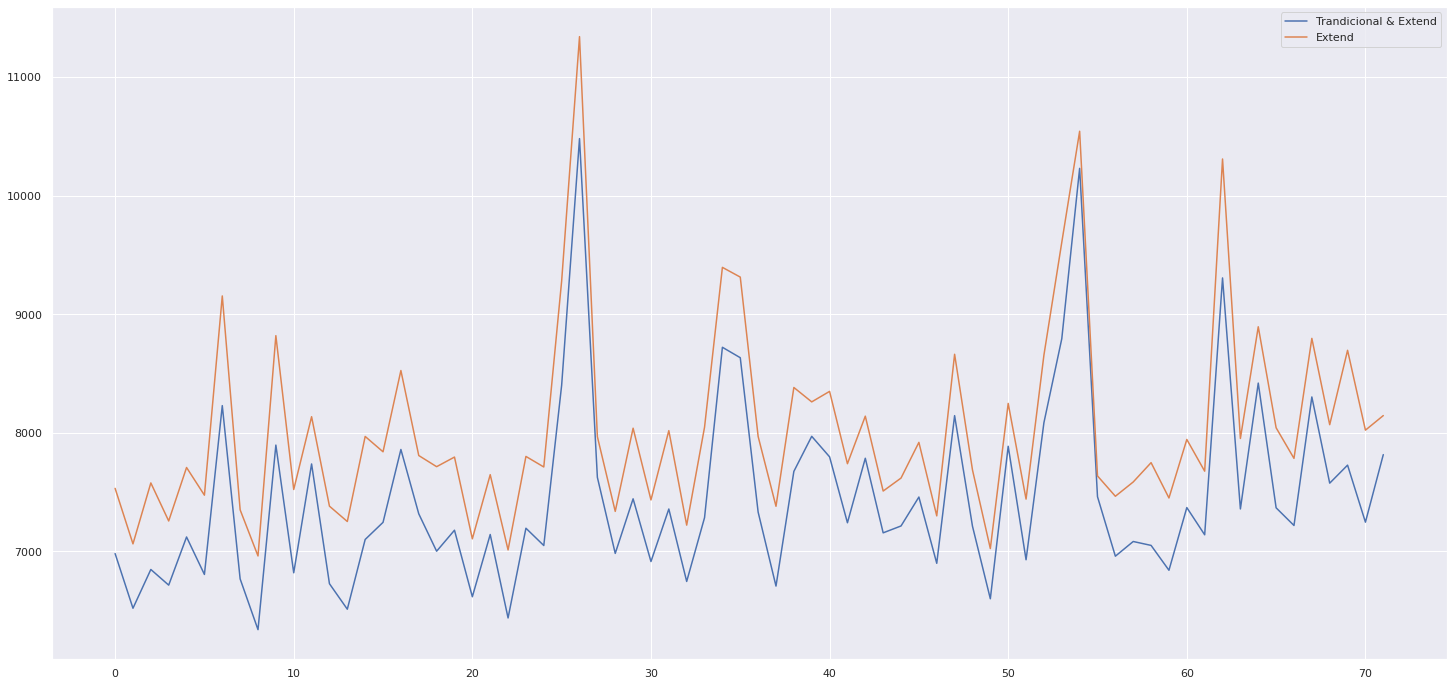

In [35]:
#select the store with regular promo and promo extend. 
aux1 = df4.loc[ (df4['promo']==1) & (df4['promo2']==1)][['sales','year_week']].groupby('year_week').median().reset_index()
plot1 = aux1.plot();
plot1

aux2 = df4.loc[ (df4['promo']==1) & (df4['promo2']==0)][['sales','year_week']].groupby('year_week').median().reset_index()
plot2 = aux2.plot(ax = plot1);

plot2;

plot1.legend(labels= ['Trandicional & Extend', 'Extend'] );

## H7 - Lojas abertas durante o feriado de Natal deveriam vender mais.

### Falso: Lojas abertas durante o feriado de Natal vendem menos.

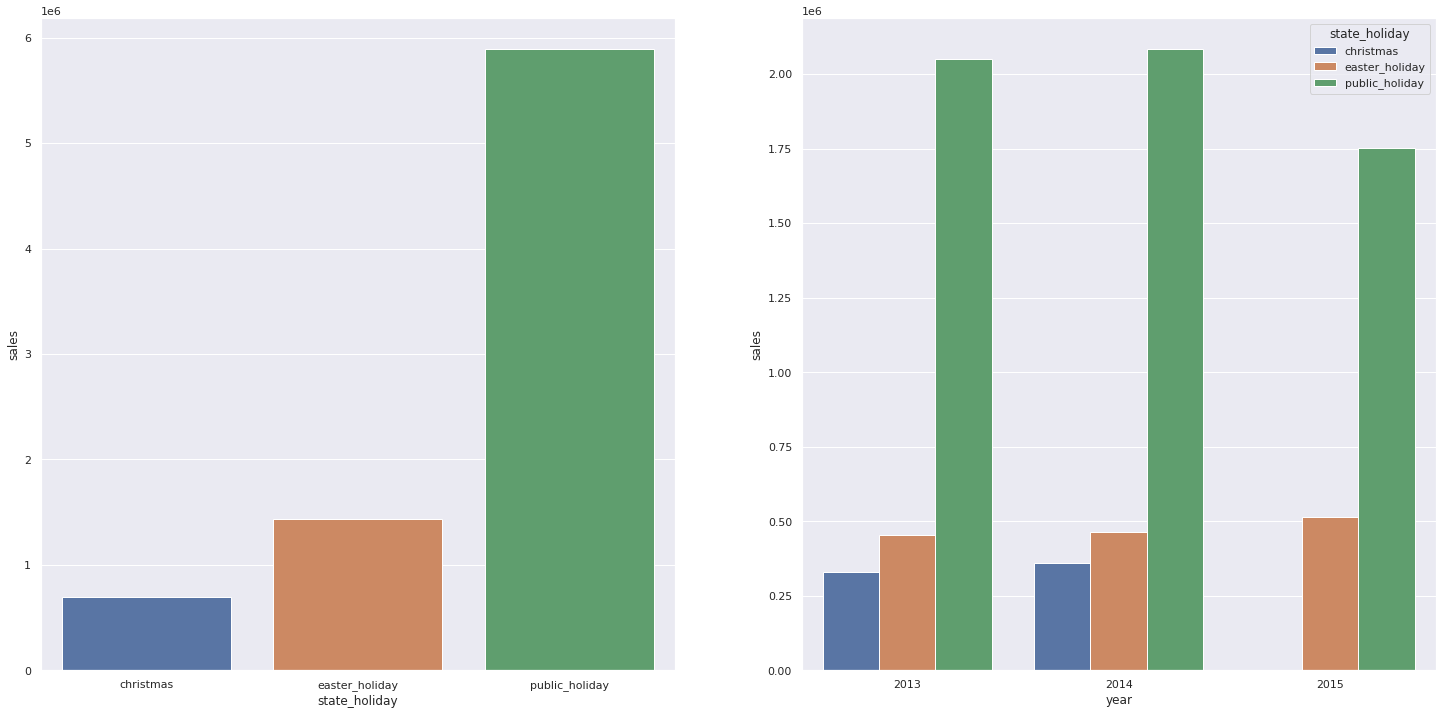

In [36]:
# ========= Comparative between the Holidays ====================#


aux = df4.loc[df4['state_holiday'] !='regular_day']

aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x ='state_holiday', y= 'sales', data = aux1);


# ========= Comparative holiday by year ==================#

aux2 = aux[['state_holiday','sales','year']].groupby(['state_holiday','year']).sum().reset_index()

plt.subplot(1,2,2)
sns.barplot(x ='year', y = 'sales', hue ='state_holiday', data= aux2);

## H8 - Lojas deveriam vender mais ao longo dos anos.

### Falso: Lojas vendem menos ao longo dos anos.

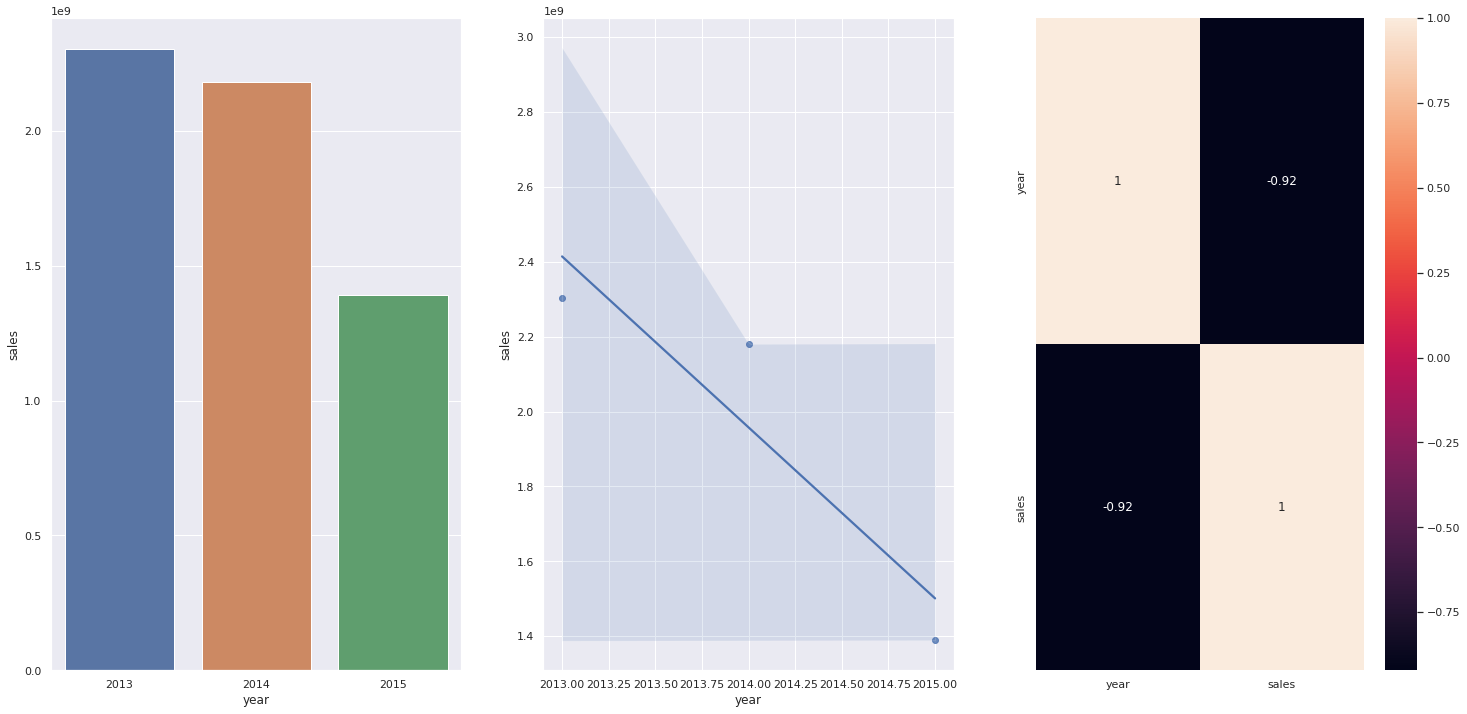

In [37]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'year', y= 'sales', data= aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'year', y = 'sales', data= aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method ='pearson'), annot=True);

## H9 - Lojas deveriam vender mais no segundo semestre do ano.

### Falso : Lojas NÃO vendem mais no SEGUNDO semestre do ano.

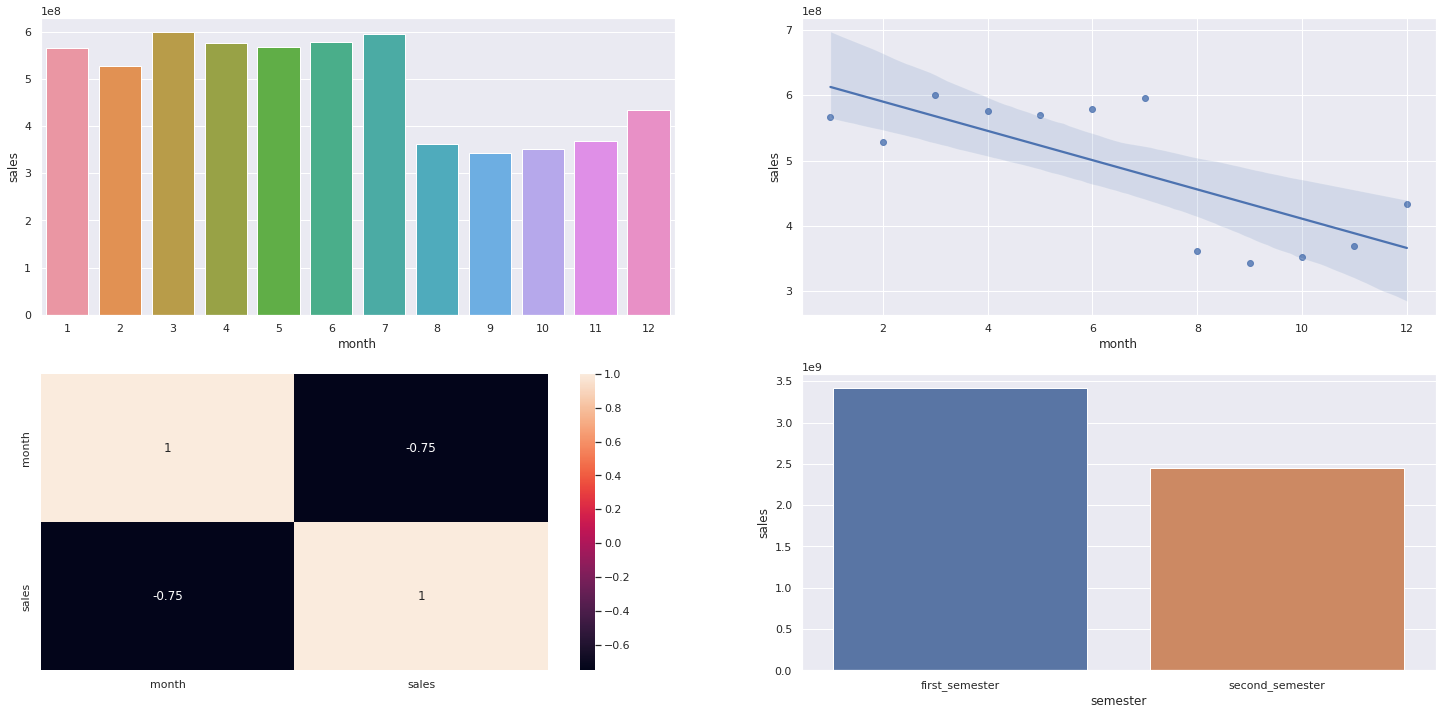

In [38]:
#grouping and ordering the month and sales
aux = df4[['sales', 'month']].groupby('month').sum().reset_index()

#plot the all month
plt.subplot(2,2,1)
sns.barplot(x= 'month', y = 'sales', data = aux);

plt.subplot(2,2,2)
sns.regplot(x= 'month', y = 'sales', data = aux);

plt.subplot(2,2,3)
sns.heatmap(aux.corr(method='pearson'), annot = True);

# ========= split the year in semester  ============= #

aux['semester'] = aux['month'].apply(lambda x: 'first_semester' if x <=6 else 'second_semester')

aux1 = aux[['semester','sales']].groupby('semester').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x = 'semester', y = 'sales', data= aux1);


## H10 - Lojas deveriam vender mais depois do dia 10 de cada mês.

# Verdade : Lojas vendem MAIS após o dia 10 de cada mês.

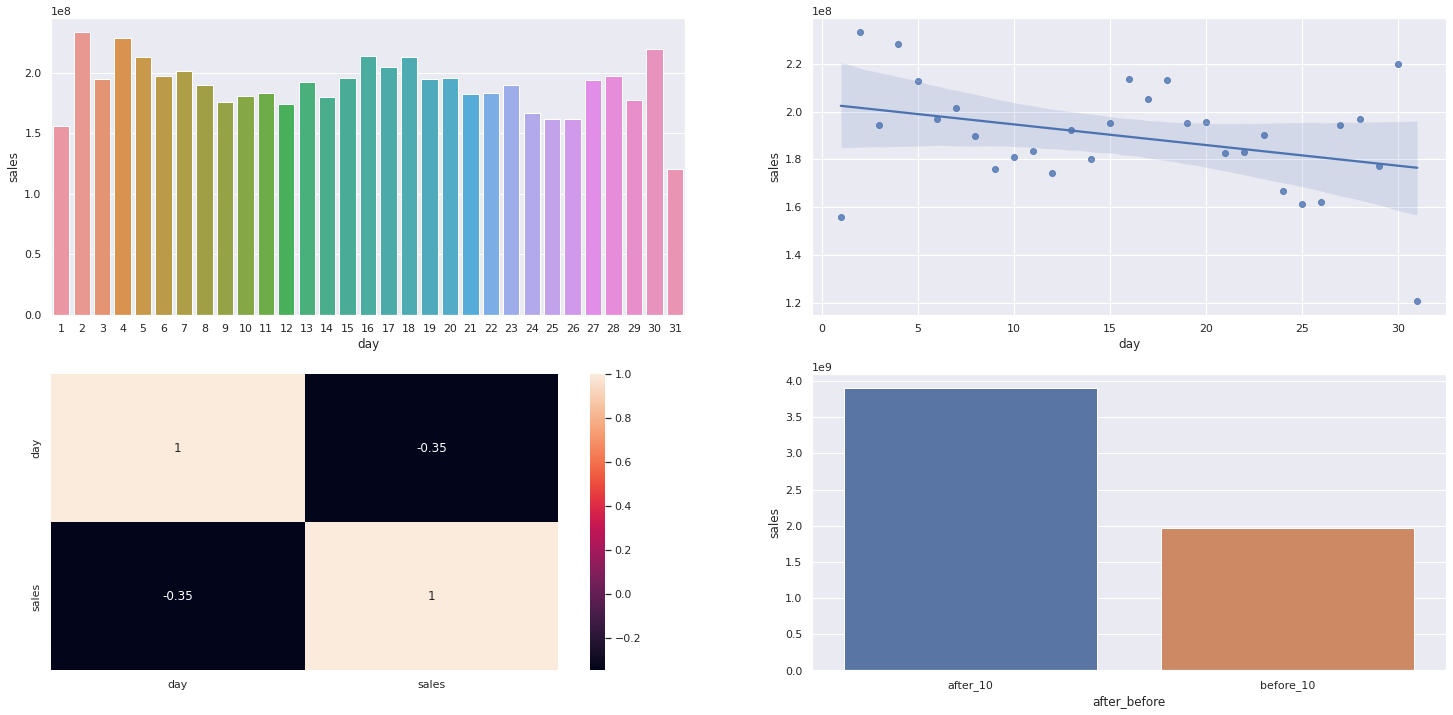

In [39]:
aux = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day', y = 'sales', data = aux);

plt.subplot(2,2,2)
sns.regplot(x = 'day', y = 'sales', data = aux);

plt.subplot(2,2,3)
sns.heatmap(aux.corr(method = 'pearson'), annot = True);

#================== filtering the data ===============================#

aux['after_before'] = aux['day'].apply(lambda x: 'after_10' if x > 10 else 'before_10')

after_before = aux[['after_before','sales']].groupby('after_before').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x = 'after_before', y = 'sales', data= after_before);

## H11 Lojas deveriam vender menos aos finais de semana.

### Verdade: Lojas vendem menos aos finais de semana.

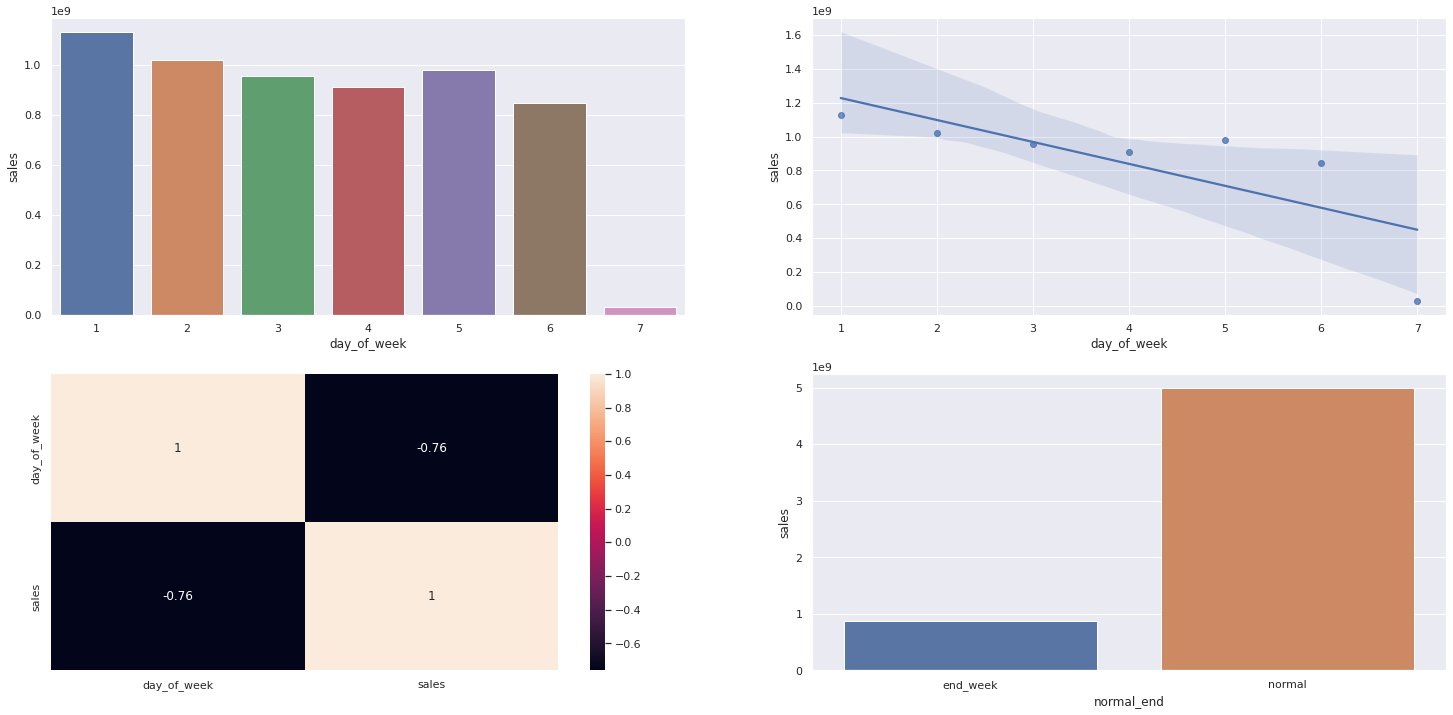

In [40]:
aux = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux);

plt.subplot(2,2,2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux);

plt.subplot(2,2,3)
sns.heatmap(aux.corr(method = 'pearson'), annot = True);

#====================== iltering the days of week ===================
aux['normal_end'] = aux['day_of_week'].apply(lambda x: 'end_week' if x >=6 else 'normal')

days = aux[['normal_end','sales']].groupby('normal_end').sum().reset_index()
plt.subplot(2,2,4)
sns.barplot(x = 'normal_end', y = 'sales', data = days);

## H12 - Lojas deveriam vender menos durante os feriados escolares.

### Verdade: Lojas vendem menos durante os feriados escolares, exceto Julho e Agosto.

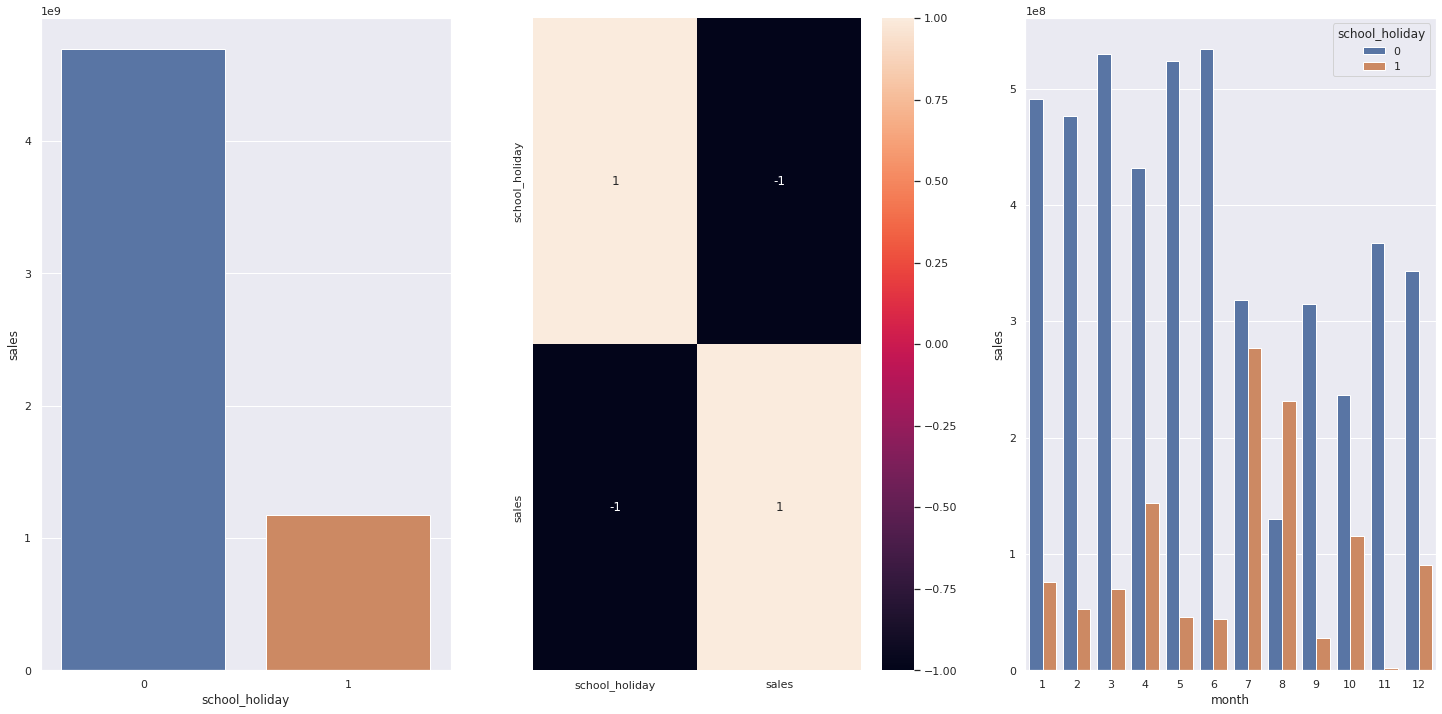

In [41]:
aux = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'school_holiday', y = 'sales', data= aux);

plt.subplot(1,3,2)
sns.heatmap(aux.corr(method = 'pearson'), annot = True);

# ======== Comparative by month =========================================# 

aux1 = df4[['school_holiday','month','sales']].groupby( ['month','school_holiday'] ).sum().reset_index()

plt.subplot(1,3,3)
sns.barplot(x = 'month', y = 'sales', hue='school_holiday', data= aux1);

## 4.2.1 Summary Hypothesis

In [42]:
tab = [ 
['Hypothesis','Conclusion', 'Relevance'], 
['H1', '- -',  '- -'],      
['H2','False','Mean'], 
['H3','False','High'],
['H4','False','Alta'],
['H5','False','High'],
['H6','False','High'], 
['H7','True' , 'Low'],
['H8','False','Mean'],
['H9','False','High'], 
['H10','True','High'], 
['H11','True','High'],
['H12','True','High'],]
      
print(tabulate(tab, headers = 'firstrow'))   
        

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            - -           - -
H2            False         Mean
H3            False         High
H4            False         Alta
H5            False         High
H6            False         High
H7            True          Low
H8            False         Mean
H9            False         High
H10           True          High
H11           True          High
H12           True          High


## 4.3 - Analyst Multivariable 

## 4.3.1 Numerical Attributes

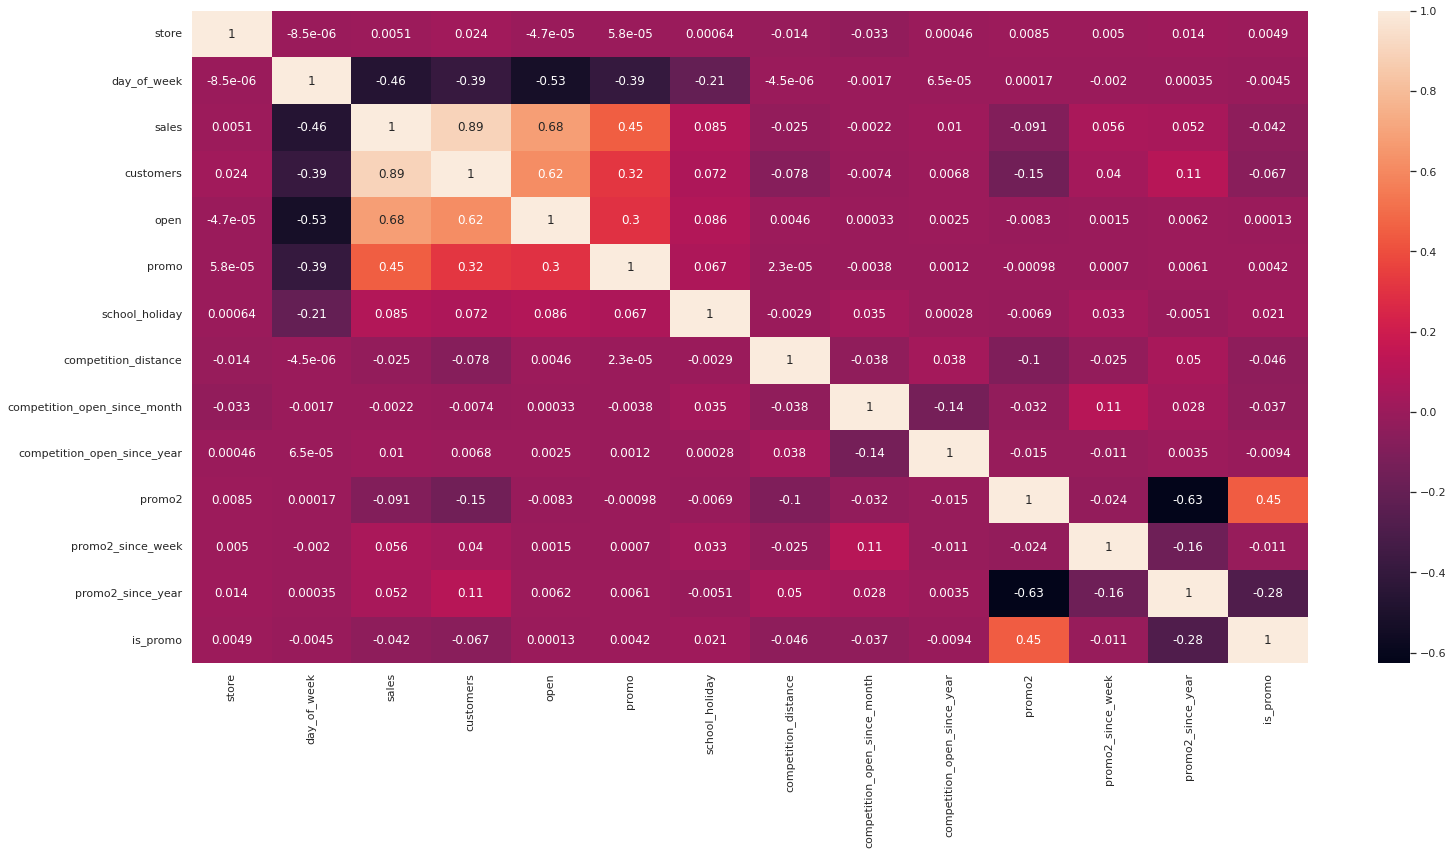

In [43]:
sns.heatmap(num_attributes.corr(method = 'pearson'), annot= True);

## 4.3.2 Categorical Attributes

In [44]:
#only variable of types object 
categorical = df4.select_dtypes( include = ['object'] )

categorical.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [45]:
#making dataframe of correlation with variable the columns of types object
df_categorical =  corr_matrix( categorical, ['state_holiday', 'store_type','assortment'])

df_categorical


,state_holiday,store_type,assortment
state_holiday,1.000000,0.071040,0.067519
store_type,0.071040,1.000000,0.538454
assortment,0.067519,0.538454,1.000000


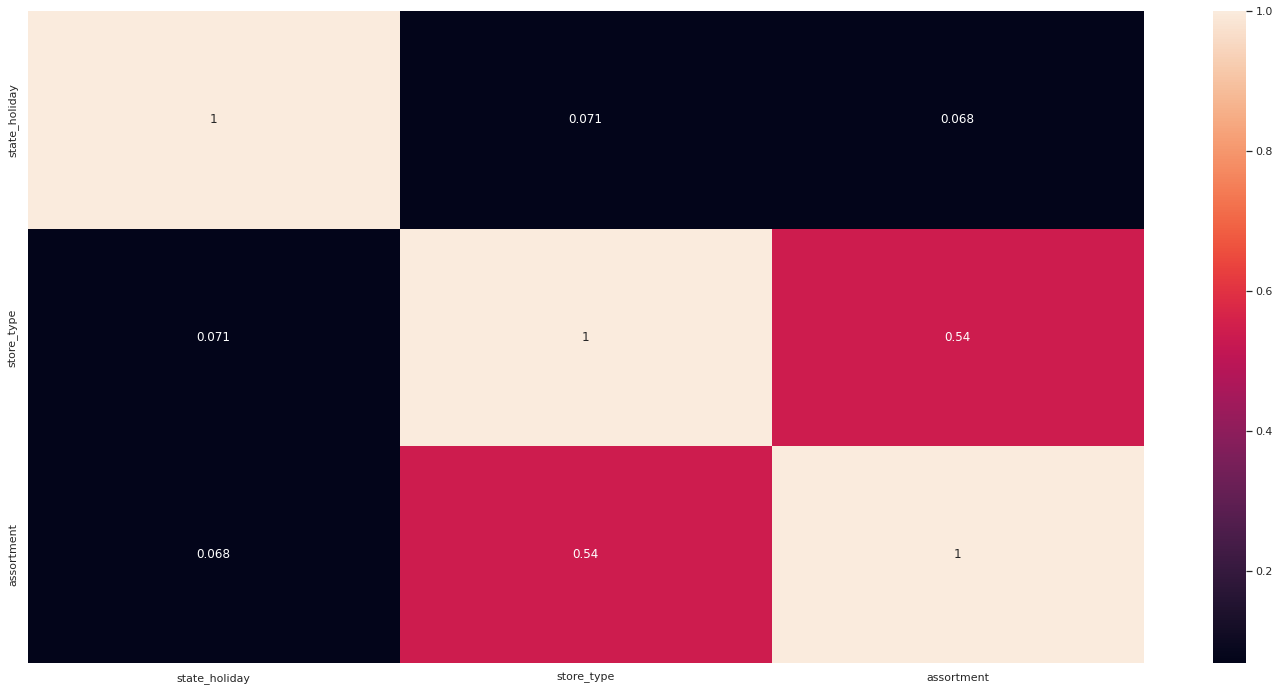

In [46]:
#plot of correlation between variable categoricals
sns.heatmap( df_categorical, annot = True);

# 5 - Data Preparation

In [77]:
df5 = df4.copy(deep=True)

## 5 . 1 Normalization Data

* Olhando o tópico Numerical Variable do item 4 é possível verificar que não há nenhum distribuição normal dos dados 

## 5.2 Rescaling

In [78]:
selection = df5.select_dtypes( include = ['int64', 'float64'] )

m1

,attributes,mean,median,min,max,range,std,skew,kurtosis
0,store,558.429727,558.0,1.0,1115.0,1114.0,321.908493,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.0,7.0,6.0,1.997390,0.001593,-1.246873
2,sales,5773.818972,5744.0,0.0,41551.0,41551.0,3849.924283,0.641460,1.778375
3,customers,633.145946,609.0,0.0,7388.0,7388.0,464.411506,1.598650,7.091773
4,open,0.830107,1.0,0.0,1.0,1.0,0.375539,-1.758045,1.090723
5,promo,0.381515,0.0,0.0,1.0,1.0,0.485758,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.0,1.0,1.0,0.383056,1.677842,0.815154
7,competition_distance,5935.442677,2330.0,20.0,200000.0,199980.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,6.786849,7.0,1.0,12.0,11.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,1900.0,2015.0,115.0,5.515591,-7.235657,124.071304


In [79]:
selection.head(3)

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,compettion_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,105,226


In [80]:
rs = RobustScaler()

mmr = MinMaxScaler()

#competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump(rs, open( '/home/guilherme/Documentos/repos/datascienceemproducao/parameter/competition_distance_scaler.pkl_scaler', 'wb') )


#competition_time_month
df5['compettion_time_month'] = rs.fit_transform( df5[['compettion_time_month']].values )
pickle.dump(rs , open( '/home/guilherme/Documentos/repos/datascienceemproducao//parameter/compettion_time_month.pkl_scaler', 'wb') )

#promo_time_week
df5['promo_time_week'] = mmr.fit_transform( df5[['promo_time_week']].values )
pickle.dump(mmr , open( '/home/guilherme/Documentos/repos/datascienceemproducao//parameter/promo_time_week.pkl_scaler', 'wb') )

#year
df5['year'] = mmr.fit_transform( df5[['year']].values )
pickle.dump(mmr , open( '/home/guilherme/Documentos/repos/datascienceemproducao//parameter/year.pkl_scaler', 'wb') )

## 5. 3 Transformation

## 5.3.1 - Response Variable Transformation

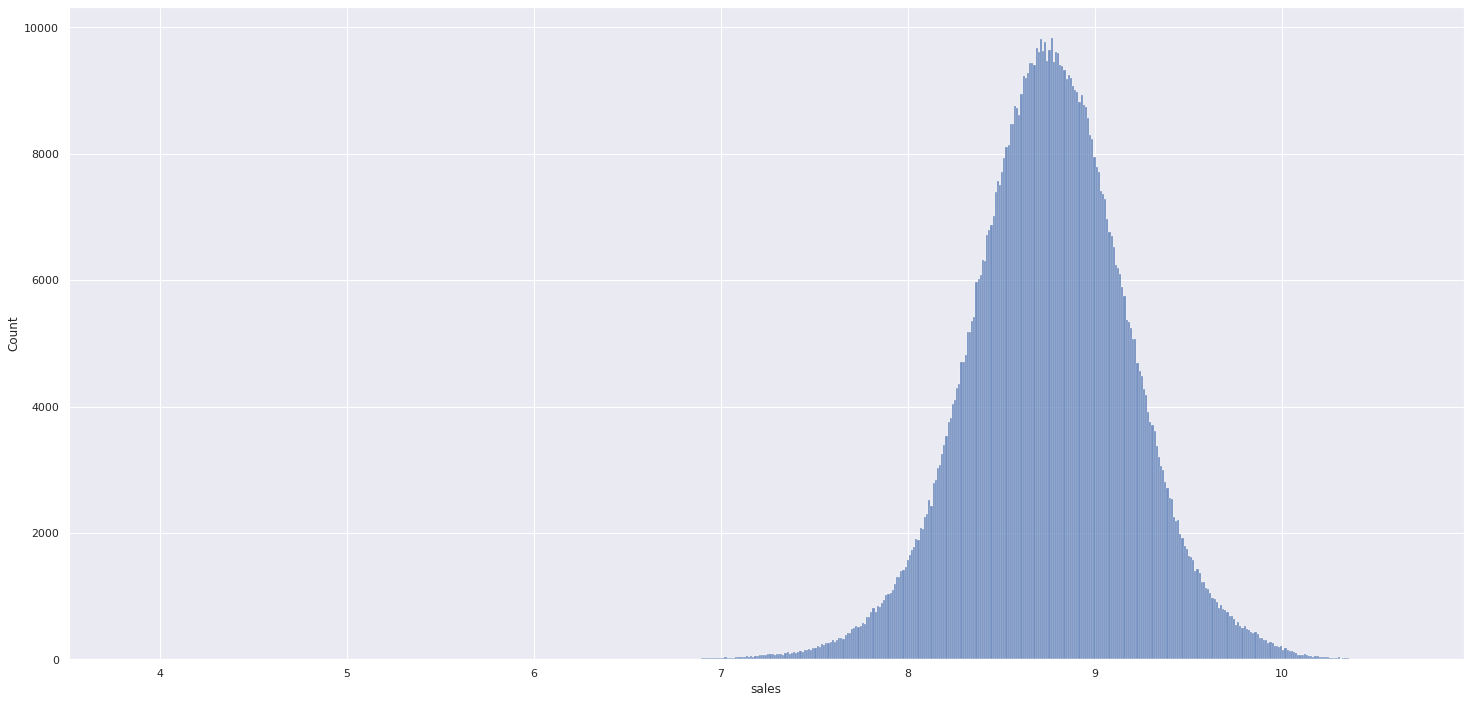

In [81]:
#transformation in a sclae log
df5['sales'] = np.log1p( df5['sales'] )

#plot response variable transformated
sns.histplot( x= 'sales', data = df5 );

## 5.3.2 Enconding

In [82]:
# ======================================= state_holiday ====================================== #

# One Hot Enconding

df5 = pd.get_dummies( df5, prefix= ['st_holiday'], columns = ['state_holiday'] )


# ====================================== store type ============================================ #

# Label Enconding 

le =LabelEncoder()

df5['store_type_encoded'] = le.fit_transform(df5.store_type)
pickle.dump(le, open( '/home/guilherme/Documentos/repos/datascienceemproducao/parameter/store_type_encoded_scaler.pkl', 'wb' ) )

# ===================================== assortment ============================================== #

# Ordinal Encoding

#created dictionary referencial
types_assortment = {'basic': 1,
                   'extended':2,
                   'extra': 3 } 

df5['assortment_ordinal'] = df5.assortment.map(types_assortment)

## 5.3.3 Nature Transformation

In [53]:
# ===================================== day ========================================== #

df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2 * np.pi/ 7 ) ) ) 
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2 * np.pi/ 7 ) ) )


# ==================================== day of week ========================================= #

df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2 * np.pi/ 7 ) ) ) 
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2 * np.pi/ 7 ) ) )



# ==================================== month =============================================== #

df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2 * np.pi / 12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2 * np.pi / 12 ) ) )

# ==================================== week of year ========================================= #

df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2 * np.pi/ 53 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2 * np.pi/ 53 ) ) )

# 6 - Feature Selection

In [54]:
df6 = df5.copy(deep=True)

## 6.1 Split Dataframe between train and test dataset

In [55]:
#making the list to remove the original features and that are object
cols_drop = ['competition_since','promo_since','year_week','week_of_year','day','day_of_week','month','assortment','store_type']

#drop the original drop
df6 = df6.drop(cols_drop, axis=1)



## 6.2 Boruta as Feature Selection

In [56]:
#discovering the date like baseline to train and test
inicial_date = df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 7* 6)

inicial_date

#training dataset
X_train = df6.loc[df6['date'] < '2015-06-19']

y_train = X_train['sales']

#testing dataset

X_test = df6.loc[df6['date']>= '2015-06-19']
y_test = X_test['sales']

#verication the date of train and test
print('Training Min Date: {}'.format(X_train['date'].min() ) )
print('Training Max Date: {}'.format(X_train['date'].max() ) )

print('\nTesting Min Date: {}'.format(X_test['date'].min() ) )
print('Testing Max Date: {}'.format(X_test['date'].max() ) )


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Testing Min Date: 2015-06-19 00:00:00
Testing Max Date: 2015-07-31 00:00:00


## 6.2.1 Boruta as Feature Selection

#deleting the feature date and sales and collecting only values in Dataset,

X_train_n = X_train.drop( ['date','sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

## Algoritm select to Borutapy
rf = RandomForestRegressor(n_jobs= -1)

#define the Boruta
#boruta= BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n,y_train_n)

boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )


#ranking the best feature selected from boruta
cols_selected = boruta.support_.tolist()

X_train_fs = X_train.drop( ['date','sales'], axis= 1)

#discovering the names of features selected 
cols_selected__boruta = X_train_fs.iloc[:, cols_selected ].columns.to_list()

#not selected from Borutapy / Making compation between array
cols_not_selected = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3 Manuel Features Selection

In [57]:
cols_select_names_boruta = [
    'store',
    'promo',
    'store_type_encoded',
    'assortment_ordinal',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'compettion_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

#recolating feature date and sales
feat_to_add = ['date','sales']

#final features
cols_select_names_boruta.extend(feat_to_add)

In [58]:
cols_select_names_boruta

['store',
 'promo',
 'store_type_encoded',
 'assortment_ordinal',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'compettion_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

# 7.0 Machine Learning Models 

In [59]:
df7 = df6.copy(deep=True)

In [60]:
#remove the features date and sales this momento to not has overfit
cols_select_names_boruta = cols_select_names_boruta[:-2]

## 7.1 Average Model

In [61]:
#created dataset with the feature selected from boruta (All variable import to model)
x_train = X_train[cols_select_names_boruta]
x_test =  X_test[cols_select_names_boruta]


In [62]:
#adicionando novamente as features date and sales
cols_select_names_boruta.extend(feat_to_add)

#creating new variable with all columns selected by Boruta
all_cols_selected_boruta = cols_select_names_boruta.copy()

#Time series data preparation / colecting just the features that was seleceted by boruta
x_training = X_train[all_cols_selected_boruta]

In [64]:
aux1 = x_test.copy(deep=True)

#add the feature sales(test) to make the prediction 
aux1['sales'] = y_test.copy(deep=True)

#prediction mean of sales by store
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns= {'sales':'predictions'} )

#performace
aux1 = pd.merge(aux1, aux2, how='left', on='store')

yhat_baseline = aux1['predictions']

baseline_result = ml_error('Average model', np.expm1(y_test), np.expm1(yhat_baseline ))
baseline_result

,Model name,Mae,Mape,Rmse
0,Average model,1354.800353,0.2064,1835.135542


## 7.2 Linear Regression Model

In [65]:
#model 
lr = LinearRegression().fit( x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#peformance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr) )

lr_result

,Model name,Mae,Mape,Rmse
0,Linear Regression,1867.251154,0.293946,2662.811846


## 7.2.1 Linear Regression - Cross Validation 

In [66]:
#(xtraining, kfold, model_name, model, verbose=False):
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression-CV', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression-CV,2036.42 +/- 273.82,0.3 +/- 0.02,2863.19 +/- 450.99


## 7.3 Linear Regression Lasso

In [67]:
#model 
lss = Lasso(alpha = 0.01).fit(x_train, y_train)

#predict 
yhat_lss= lss.predict(x_test)

#peformance
lss_result = ml_error('Linear Regression-Lasso', np.expm1(y_test), np.expm1(yhat_lss) )

lss_result

,Model name,Mae,Mape,Rmse
0,Linear Regression-Lasso,1895.343972,0.289598,2748.918141


## 7.3.1 Linear Regression Lasso - Cross Validation

In [68]:
lss_result_cv = cross_validation(x_training, 5, 'Linear Regression-Lasso-CV', lss, verbose=False)

lss_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression-Lasso-CV,2069.32 +/- 329.24,0.29 +/- 0.01,2960.02 +/- 508.61


## 7.4 Random Forest Regressor

In [69]:
#model 
rf =  RandomForestRegressor(n_jobs=-1, n_estimators=100, random_state=42).fit(x_train, y_train)
#predict 
yhat_rf= rf.predict(x_test)

#peformance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf) )

rf_result

,Model name,Mae,Mape,Rmse
0,Random Forest Regressor,644.593713,0.095508,952.63999


## 7.4.1 Random Forest Regressor - Cross Validation 

In [70]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest -CV', rf, verbose=False)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest -CV,837.59 +/- 218.04,0.12 +/- 0.02,1232.55 +/- 338.98


## 7.5 XGBoost Regressor Model

In [71]:
#model 
model_xb = xgb.XGBRegressor().fit(x_train, y_train)
#prediction 
yhat_xgb = model_xb.predict(x_test)

#peformance
xgb_result = ml_error('XgBoost Regressor Model', np.expm1(y_test), np.expm1(yhat_xgb) )

xgb_result

,Model name,Mae,Mape,Rmse
0,XgBoost Regressor Model,920.605799,0.135897,1327.657702


## 7.5.1  XGBoost Regressor Model - Cross Validation

In [73]:
xgb_result_cv = cross_validation(x_training, 5, 'XgBoost Regressor -CV', model_xb, verbose=False)
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XgBoost Regressor -CV,1069.73 +/- 232.37,0.15 +/- 0.03,1521.13 +/- 351.27


## 7.6 Comparasion Between Peformance Model

## 7.6.1 - Performance Single KFold

In [74]:
modeling_result = pd.concat( [baseline_result, lr_result, lss_result, rf_result, xgb_result] )

modeling_result.sort_values('Rmse')

,Model name,Mae,Mape,Rmse
0,Random Forest Regressor,644.593713,0.095508,952.639990
0,XgBoost Regressor Model,920.605799,0.135897,1327.657702
0,Average model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.251154,0.293946,2662.811846
0,Linear Regression-Lasso,1895.343972,0.289598,2748.918141


## 7.6.2 - Performance Real - Cross Validation

In [78]:
result_real = pd.concat( [lr_result_cv, lss_result_cv, rf_result_cv, xgb_result_cv] )

result_real.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest -CV,837.59 +/- 218.04,0.12 +/- 0.02,1232.55 +/- 338.98
0,XgBoost Regressor -CV,1069.73 +/- 232.37,0.15 +/- 0.03,1521.13 +/- 351.27
0,Linear Regression-CV,2036.42 +/- 273.82,0.3 +/- 0.02,2863.19 +/- 450.99
0,Linear Regression-Lasso-CV,2069.32 +/- 329.24,0.29 +/- 0.01,2960.02 +/- 508.61


# 8 - Hyparameter Fine Turning

In [63]:
df8 = df7.copy(deep=True)

## 8.1 - Strategy Random Seach

In [85]:
#creating the values random to combination and adjust of Hyparameter
param = {'n_estimators': [15, 17 , 25 , 30 , 35 ],
        'eta' : [0.01, 0.03], 
        'max_depth' : [3 , 5 ,9], 
        'subsample' : [0.1 , 0.5 , 0.7],
        'colsample_bytree': [0.3 , 0.7 , 0.9],
        'min_child_weight': [3 , 8 , 15] }

#Set values that the strategy Random Will be to combine
max_eval = 5

In [99]:
#creating Data Frame to insert values of Hyparameters finded
final_result = pd.DataFrame()

for i in range( max_eval ):
    #choose the values for parameters ramdomly
    hp = { k: random.sample( v, 1)[0] for k, v in param.items() }
    print( hp )
    
    #model 
    model_xb = xgb.XGBRegressor(objective ='reg:squarederror',
                                n_estimators = hp['n_estimators'], 
                                eta = hp['eta'],
                                max_depth = hp['max_depth'],
                                subsample = hp['subsample'],
                                colsample_bytree = hp['colsample_bytree'],
                                min_child_weight = hp['min_child_weight'])

    #peformance
    result = cross_validation(x_training, 2, 'XgBoost Regressor Model', model_xb ,verbose=False )
    
    # merge the result in DataFrame 
    final_result = pd.concat( [final_result, result] )

final_result

{'n_estimators': 35, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 25, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XgBoost Regressor Model,7383.15 +/- 110.23,1.0 +/- 0.0,7961.49 +/- 202.32
0,XgBoost Regressor Model,7264.96 +/- 111.16,0.98 +/- 0.0,7850.04 +/- 205.22


## 8.2 - Final Model

In [69]:
# variable with the set values that best were combined
param_turned = {'n_estimators': 3000,
                'eta' :0.03 , 
                'max_depth':5 , 
                'subsample' : 0.5 ,
                'colsample_bytree': 0.7 ,
                'min_child_weight': 3 }


In [70]:
#model 
model_xb_turned = xgb.XGBRegressor(objective ='reg:squarederror',
                                n_estimators = param_turned['n_estimators'], 
                                eta = param_turned['eta'],
                                max_depth = param_turned['max_depth'],
                                subsample = param_turned['subsample'],
                                colsample_bytree = param_turned['colsample_bytree'],
                                min_child_weight = param_turned['min_child_weight']).fit(x_train, y_train)

#prediction
yhat_xb_turned = model_xb_turned.predict(x_test)
    
#peformance
xgb_result_turned = ml_error('XgBoost Regressor Model', np.expm1(y_test), np.expm1(yhat_xb_turned) )

xgb_result_turned

,Model name,Mae,Mape,Rmse
0,XgBoost Regressor Model,794.01208,0.11992,1130.947487


In [74]:
# Saving the model machine learning with Parameter selecteds
pickle.dump(model_xb_turned, open( '/home/guilherme/Documentos/repos/datascienceemproducao/model/model_rossmann.pkl', 'wb' ) )

# 9 - Translate and Intepretation of Error

In [64]:
#opening the file the model turned.
model_xgb_turned = pickle.load( open ('/home/guilherme/Documentos/repos/datascienceemproducao/model/model_rossmann.pkl','rb' ) )

#making predict of sales
yhat_xb_turned = model_xgb_turned.predict(x_test)

In [65]:
#creating the copy with features select by Boruta
df9 = X_test[all_cols_selected_boruta].copy(deep=True)

#rescaling the variables  
df9['sales'] = np.expm1( df9['sales'] )

#Feature the feature with the best parameters of sales
df9['predictions'] = np.expm1( yhat_xb_turned )

## 9.1 -  Bussiness Performance


 


In [66]:
#sum of prediction by store

df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

#MAE and MAPE
df9_aux1 = df9[['store', 'predictions','sales']].groupby('store').apply(lambda x:mean_absolute_error
                                                                        ( x['sales'], x['predictions'] )
                                                                       ).reset_index().rename(columns={0:'MAE'})

df9_aux2 = df9[['store','predictions', 'sales']].groupby('store').apply(lambda x: mean_absolute_percentage_error
                                                                        ( x['sales'], x['predictions'] ) 
                                                                        ).reset_index().rename(columns={0:'MAPE'} ) 

#merge dataframe auxiliaries
df9_aux3 = pd.merge(df9_aux1,df9_aux2, how='inner', on= 'store')

#merge dataframe auxiliaries with the dataframe original
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

#Scenarios 
df92['worst_scenario'] = df92['predictions'] - df92['MAPE']

df92['best_scenario'] = df92['predictions'] + df92['MAPE']

#order the columns 
df92 = df92[['store','predictions', 'best_scenario', 'worst_scenario', 'MAE', 'MAPE']]

##  9.1.1 - Stores Performances 

In [67]:
#stores with less erros
df92.sort_values( ['MAPE']).head()

,store,predictions,best_scenario,worst_scenario,MAE,MAPE
1088,1089,377792.40625,377792.461136,377792.351364,568.940865,0.054886
258,259,555878.12500,555878.180920,555878.069080,677.860215,0.055920
741,742,298727.87500,298727.932730,298727.817270,463.810903,0.057730
1066,1067,225175.46875,225175.529502,225175.407998,383.826568,0.060752
614,615,345200.28125,345200.342364,345200.220136,548.099372,0.061114


In [68]:
#stores with the biggers errors
df92.sort_values(['MAPE'], ascending=False).head()

,store,predictions,best_scenario,worst_scenario,MAE,MAPE
291,292,108219.468750,108220.056741,108218.880759,3341.765085,0.587991
908,909,229240.000000,229240.523708,229239.476292,7811.179645,0.523708
901,902,210764.468750,210764.893939,210764.043561,1698.823467,0.425189
169,170,211464.656250,211465.048158,211464.264342,1608.450209,0.391908
875,876,199683.078125,199683.423907,199682.732343,4176.728197,0.345782


## 9.2 - Total Performance

In [69]:
#suming the values of scenarios 
df93 = df92[['predictions','worst_scenario','best_scenario']].apply( lambda x: np.sum (x) 
                                                            ).reset_index().rename(columns={'index':'Scenarios',0:'Values'})
#formatting the values to currency reais
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )

df93

,Scenarios,Values
0,predictions,"R$287,726,528.00"
1,worst_scenario,"R$287,726,366.55"
2,best_scenario,"R$287,726,634.87"


## 9.3 - Machine Learning Performance

In [70]:
# New columns of error between sales and predictions of each store 
df9['error'] = df9['sales'] - df9['predictions']

#percentage of error between predctions and sales of each store
df9['error_rate'] = df9['predictions'] / df9['sales']

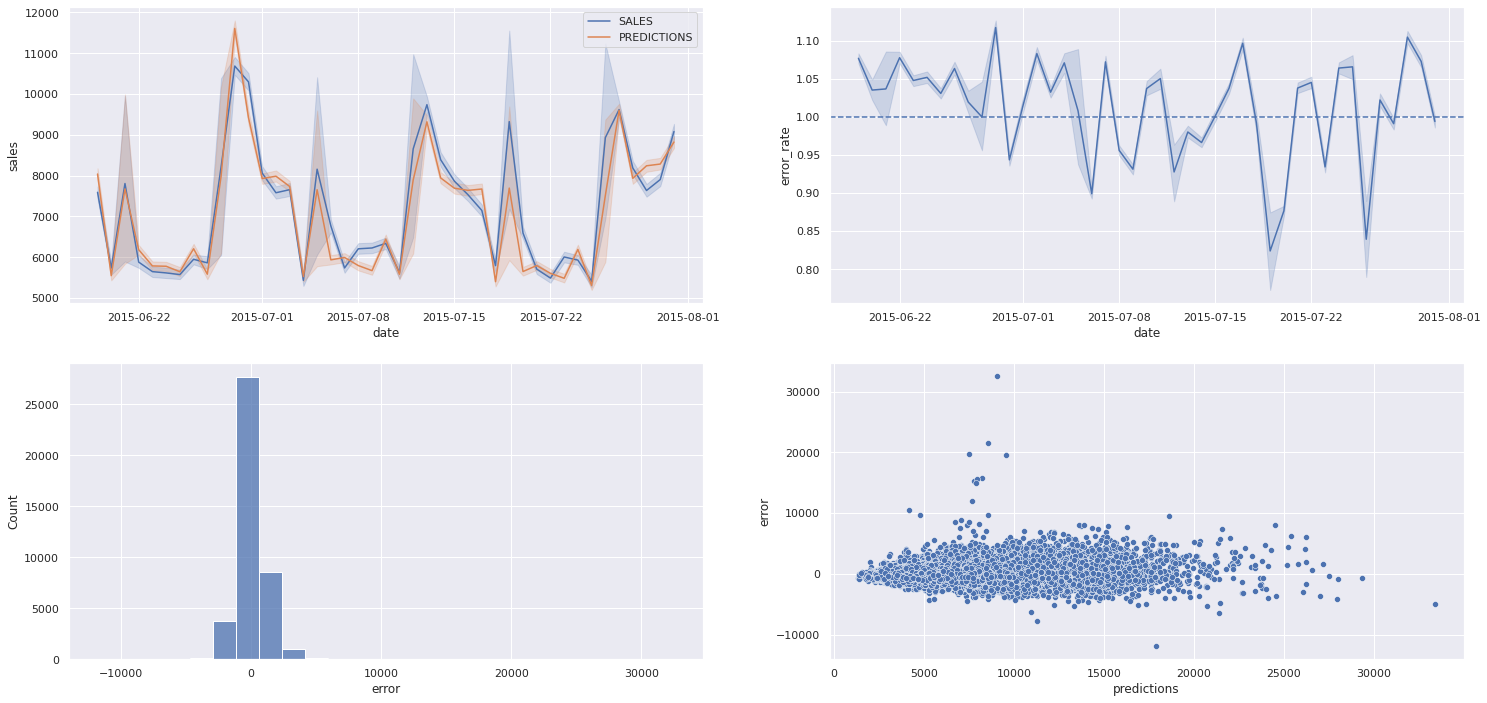

In [71]:
plt.subplot(2 ,2 , 1)
sns.lineplot(x = df9['date'], y = df9['sales'], data = df9, label = 'SALES' );
sns.lineplot(x = df9['date'], y = df9['predictions'], data = df9, label= 'PREDICTIONS');

plt.subplot(2 , 2 ,2)
sns.lineplot( x = df9['date'], y = df9['error_rate'] , data = df9 );
plt.axhline(1, linestyle = '--');

plt.subplot(2 , 2 , 3)
sns.histplot(df9['error'],bins=25);

plt.subplot(2, 2 , 4)
sns.scatterplot(x = df9['predictions'], y = df9['error']);

* 1 - Gráfico : Apresenta as variações entre as vendas e previsões de cada loja.

* 2 - Gráfico : Apresenta as oscilações em porcetagem das previsões em relações as vendas das lojas. Sendo  que se o modelo for negativo ele estará sub-estimado e positivo super-estimado as vendas. O ideal é que estivesse em linha com o traço pontilhado.

* 3 - Gráfico : Apresenta a contagem entre das diferença númerica entre o valor da venda menos a previsão feita pelo modelo. 

* 4 - Gráfico : Apresenta a distribuição dos erros das lojas ao decorrer das previsões feitas. É possível notar que há erros mais significativos entre as predições entre 8000 à 10000


# 10 - Deploy Model Production

## 10.1 -  Rossmann Class

In [43]:
#cleaning, transformation and enconding

import pickle
import inflection
import pandas as pd
import numpy as np
import datetime
import math

class Rossmann (object):
    def __init__( self ):
        self.home_path = '/home/guilherme/Documentos/repos/datascienceemproducao/'
        self.competition_distance_scaler  = pickle.load( open(self.home_path + '/home/guilherme/Documentos/repos/datascienceemproducao/parameter/competition_distance_scaler.pkl_scaler', 'rb') )
        self.compettion_time_month_scaler = pickle.load( open(self.home_path + '/home/guilherme/Documentos/repos/datascienceemproducao//parameter/compettion_time_month.pkl_scaler', 'rb') )
        self.promo_time_week_scaler       = pickle.load( open(self.home_path + '/home/guilherme/Documentos/repos/datascienceemproducao//parameter/promo_time_week.pkl_scaler', 'rb') )
        self.year_scaler                  = pickle.load( open(self.home_path + '/home/guilherme/Documentos/repos/datascienceemproducao//parameter/year.pkl_scaler', 'rb') )
        self.store_type_encoded_scaler    = pickle.load( open(self.home_path + '/home/guilherme/Documentos/repos/datascienceemproducao/parameter/store_type_encoded_scaler.pkl', 'rb' ) )
        
    def data_cleaning(self, df1):
        

        ## 1.1  Rename Columns and Remove the Feature Sales and Customers


        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                   'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                   'CompetitionDistance', 'CompetitionOpenSinceMonth',
                   'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                   'Promo2SinceYear', 'PromoInterval']

        #function to convent columns format snackcase
        snackcase= lambda x: inflection.underscore( x )


        cols_new= list( map( snackcase, cols_old ))

        #rename columns 

        df1.columns = cols_new


        ## 1.3 Data Types

        # convent the colum data to datetime64
        df1['date'] = df1['date'].astype('datetime64[ns]')

        ## 1.5 FillOut NA

        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x )



        df1['competition_open_since_month']= df1.apply(lambda x: x['date'].month if 
                                                       math.isnan(x['competition_open_since_month']) 
                                                       else x['competition_open_since_month'], axis=1)



        df1['competition_open_since_year']= df1.apply(lambda x: x['date'].year if
                                                      math.isnan(x['competition_open_since_year']) 
                                                      else x['competition_open_since_year'],axis=1)


        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week'])
                                             else x['promo2_since_week'],axis=1)

        df1['promo2_since_year']= df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year'])
                                             else x['promo2_since_year'],axis=1)

        #dict of year to month
        month_map = {1: 'Jan',2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May',
                     6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov' ,12: 'Dec' }


        #substituindo NA por 0
        df1['promo_interval'].fillna(0,inplace=True)

        #extract month data 
        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x:0 if x['promo_interval']==0 
                                                                    else 1 if x['month_map'] in x['promo_interval'].split( ',' ) 
                                                                    else 0,axis=1)

        ## 1.6 Change Types
        
        #promo2
        df1['promo2_since_week']  = df1['promo2_since_week'] .astype(int)

        df1['promo2_since_year']  = df1['promo2_since_year'] .astype(int)
        
        #competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

        df1['competition_open_since_year'] =  df1['competition_open_since_year'].astype(int)
        
        return df1
    def feature_engineering(self, df2):
        
        df2['year']= df2['date'].dt.year

        df2['month'] = df2['date'].dt.month

        df2['day'] = df2['date'].dt.day

        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                       month=x['competition_open_since_month'],
                                                                       day=1),axis=1)

        df2['compettion_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply(lambda x: x.days).astype(int)

        #join the columns promo2
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

        # convent promo time week to datetime
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1','%Y-%W-%w') - datetime.timedelta(days=7) )


        #calcule between start promo and continuation 
        df2['promo_time_week'] = (( df2['date'] - df2['promo_since'] ) /7 ).apply(lambda x: x.days).astype(int)

        # renome names assortment 
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x== 'a' else 'extra' if x =='b'else 'extended')

        #rename state holiday

        df2['state_holiday']= df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' 
                                                         else 'easter_holiday' if x=='b' 
                                                         else 'christmas' if x=='c'
                                                         else 'regular_day')
        ## 3.1 Filtering the data

        #filtereing the rows open and sales of dataset

        df2= df2.loc[df2['open'] > 0] 

        ## 3.2 Select the columns

        cols_drop= ['open','promo_interval','month_map']

        df2 = df2.drop( cols_drop,axis=1 )
        
        return df2
    
    def data_preparation(self, df5):
        
        ## 5.2 Rescaling

        selection = df5.select_dtypes( include = ['int64', 'float64'] )

        #competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.fit( df5[['competition_distance']].values )

        #competition_time_month
        df5['compettion_time_month'] = self.compettion_time_month_scaler.fit( df5[['compettion_time_month']].values )

        #promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit( df5[['promo_time_week']].values )

        #year
        df5['year'] = self.year_scaler.fit( df5[['year']].values )

        ## 5. 3 Transformation


        ## 5.3.2 Enconding

        # ======================================= state_holiday ====================================== #

        # One Hot Enconding

        df5 = pd.get_dummies( df5, prefix= ['st_holiday'], columns = ['state_holiday'] )


        # ====================================== store type ============================================ #

        # Label Enconding 

        df5['store_type_encoded'] = self.store_type_encoded_scale.fit(df5.store_type)


        # ===================================== assortment ============================================== #

        # Ordinal Encoding

        #created dictionary referencial
        types_assortment = {'basic': 1,
                           'extended':2,
                           'extra': 3 } 

        df5['assortment_ordinal'] = df5.assortment.map(types_assortment)

        ## 5.3.3 Nature Transformation

        # ===================================== day ========================================== #

        df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2 * np.pi/ 7 ) ) ) 
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2 * np.pi/ 7 ) ) )


        # ==================================== day of week ========================================= #

        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2 * np.pi/ 7 ) ) ) 
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2 * np.pi/ 7 ) ) )



        # ==================================== month =============================================== #

        df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2 * np.pi / 12 ) ) )
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2 * np.pi / 12 ) ) )

        # ==================================== week of year ========================================= #

        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2 * np.pi/ 53 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2 * np.pi/ 53 ) ) )
        
        cols_select = ['store','promo', 'store_type_encoded','assortment_ordinal',
                                    'competition_distance', 'competition_open_since_month',
                                    'competition_open_since_year','promo2','promo2_since_week','promo2_since_year',
                                    'compettion_time_month', 'promo_time_week','day_of_week_sin','day_of_week_cos',
                                    'month_sin','month_cos','day_sin','day_cos','week_of_year_sin',
                                    'week_of_year_cos']

        
        return df5[cols_select]
    
    def get_prediction (self, model, original_data, test_data):
        #prediction
        pred - model.predict( test_data )
        
        #join predict with original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json( orient = 'records', date_format = 'iso')

## 10.2 - API Handler

In [41]:
import pickle
import pandas as pd
from flask import Flask, request, Response

#loading the model
model = pickle.load(open ('/home/guilherme/Documentos/repos/datascienceemproducao/model/model_rossmann.pkl','rb') )

#collecting the past, archive and import Class
from rossmann.Rossmann import Rossmann

#start API
app = Flask( __name__ )

#creating url (endpoint) to send data
@app.route('/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    teste_json = request.get_json()
    
    if test_json: #there is data
        
        if isinstance( test_json, dict):#Unique example
            
            #In case there is data only raw
            test_raw = pd.DataFrame(test_json, index=[0])
            
        else:
            #collect all the json of all the raws
            test_raw = pd.DataFrane(test_json, columns=test_json[0].keys() ) #Multiple examples
        
        
        #Instance Rossmann Class (Making a copy)
        pipeline = Rossmann()
        
        #data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        #featuree engineering
        df2 = pepeline.feature_engineering(df1)
        
        #data preparation
        df3 = pipeline.data_preparation(df2)
        
        #predict                              #test
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    
    else:
        return Response( '{}',status=200 , mimetype='application/json')

if __name__ == '_main_':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## 10.3 - API Test

In [45]:
import json
import requests

In [46]:
#scrip to test

#loading the file of test
df10 = pd.read_csv('/home/guilherme/Documentos/repos/datascienceemproducao/data/test.csv')

#merge the dataset for to making predction 
df_test = pd.merge(df10, df_store, how= 'left', on='Store')

#choose the store for prediction
df_test = df_test.loc[df_test['Store']==22]

In [47]:
#remove the rows and columns empty and filtering the stores that are opens
df_test = df_test.loc[(~df_test['Open'].isnull()) & (df_test['Open']!=0)]

#remove the colum id
df_test = df_test.drop('Id', axis=1)


In [48]:
#convent DataFrame to json

data = json.dumps(df_test.to_dict(orient='records') )

In [49]:
#API Call

#address call
url = 'http://0.0.0.0:5000/rossmann/predict'

#type of requisition
header = {'Content-type':'application/json'}

#data the to be collected
data = data

#send the datas
r = request.post(url, data, headers=header)

print('Status code {}'.format(r.status_code) )

RuntimeError: Working outside of request context.

This typically means that you attempted to use functionality that needed
an active HTTP request.  Consult the documentation on testing for
information about how to avoid this problem.